In [1]:
import os, csv, re
import pandas as pd
import numpy as np

import math
from scipy.sparse import issparse
import random 
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import scanpy as sc
import anndata as ad
#import cv2
import time

In [24]:
def print_adata_minmax(adata):
    print(f"minimum value: {np.amax(adata.X):0.3f}, maximum value: {np.amin(adata.X):0.3f}\n")

In [25]:
from sklearn.metrics.cluster import adjusted_rand_score

def calc_ari(adata, manual:str, predicted:str):
    return adjusted_rand_score(
        adata.obs[manual].cat.codes, 
        adata.obs[predicted].cat.codes
    )

In [26]:
from scanpy import read_10x_h5

samples = [
    "3729_Xen21", "3809_Xen22A", "3809_Xen22B", "3811_Xen21"
]

num_clusters_list = [10, 10, 10,10,10,10,10]

samples_data = {}

In [27]:
def load_multisamples_as_one(sample):
    data_path = os.path.join("/Volumes/Active/Xenium/Banksy_Atlas/", sample)  # adjust path as needed
    expr_path = os.path.join(data_path, "cell_feature_matrix.h5")
    spatial_path = os.path.join(data_path, "cells.csv")
    manual_path = os.path.join("/Volumes/Active/Xenium/Banksy_Atlas/", sample, "cell_labels.csv")

    # load expression data
    adata = sc.read_10x_h5(expr_path)  

    # load spatial data
    spatial = pd.read_csv(spatial_path)
    spatial.set_index('cell_id', inplace=True)
   
    # merge spatial info with adata.obs based on cell IDs
    adata.obs = adata.obs.merge(spatial[['x_centroid', 'y_centroid']], 
                                left_index=True, right_index=True, how='left')

    # annotations:
    manual = pd.read_csv(manual_path)
    manual.set_index('cell_id', inplace=True)
    adata.obs = adata.obs.merge(manual[['cell_label']], 
                                left_index=True, right_index=True, how='left')
    adata.obs['manual_annotations'] = adata.obs['cell_label'].fillna('other').astype('category')

    # make gene names unique, etc.
    adata.var_names_make_unique()
    return adata

In [28]:
# load multi samples into single adata
for sample in samples:
    if sample == samples[0]:
        adata = load_multisamples_as_one(sample)
        adata.obs['sample'] = sample
    else:
        adata_temp = load_multisamples_as_one(sample)
        adata_temp.obs['sample'] = sample

        # concatenate samples into one AnnData object
        adata_temp_obs = pd.concat([adata.obs, adata_temp.obs])
        adata = ad.concat([adata, adata_temp], label="sample", join="outer")
        adata.obs = adata_temp_obs

In [29]:
counts = adata.obs['sample'].value_counts().sort_index()
print("Cells per sample:")
print(counts)

Cells per sample:
sample
3729_Xen21     13859
3809_Xen22A    15610
3809_Xen22B    15498
3811_Xen21     26489
Name: count, dtype: int64


In [30]:
# filter unannotated spots if any
#adata = adata[adata.obs["manual_annotations"] != "other", :]
tar_sum = np.median(adata.X.sum(axis=1).A1)

Cells per sample:
sample
3729_Xen21     13859
3809_Xen22A    15610
3809_Xen22B    15498
3811_Xen21     26489
Name: count, dtype: int64

X‑coordinate range per sample (after staggering):
                    min          max
sample                              
3729_Xen21   555.997742  3038.120361
3809_Xen22A  319.922058  3522.887695
3809_Xen22B    7.443864  4142.839844
3811_Xen21    97.915405  2839.244385


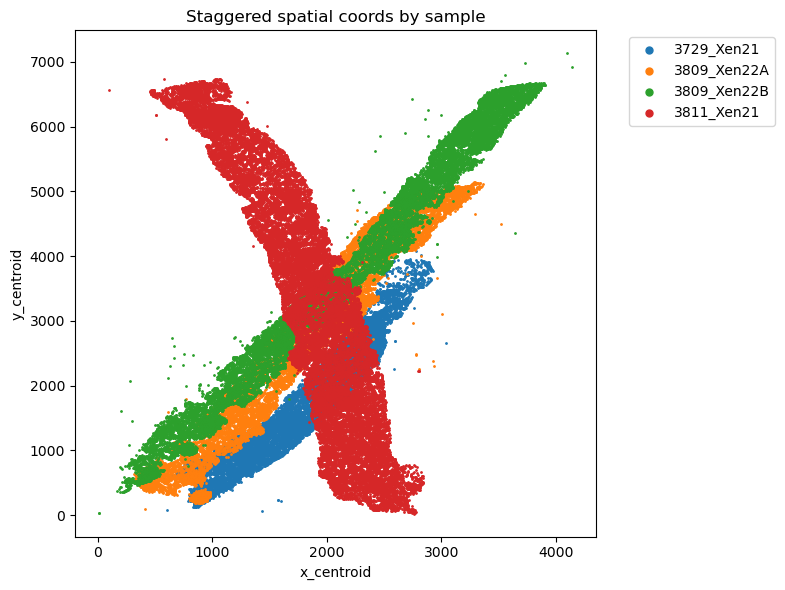

In [31]:
counts = adata.obs['sample'].value_counts().sort_index()
print("Cells per sample:")
print(counts)

# get min/max x after staggering
x_stats = adata.obs.groupby('sample')['x_centroid'].agg(['min','max'])
print("\nX‑coordinate range per sample (after staggering):")
print(x_stats)

# 3) quick scatter to visually confirm each sample’s “stripe”
fig, ax = plt.subplots(figsize=(8,6))
for sample in counts.index:
    sub = adata.obs[adata.obs['sample']==sample]
    ax.scatter(sub['x_centroid'], sub['y_centroid'], s=1, label=sample)
ax.legend(markerscale=5, bbox_to_anchor=(1.05,1), loc='upper left')
ax.set_title("Staggered spatial coords by sample")
ax.set_xlabel("x_centroid")
ax.set_ylabel("y_centroid")
plt.tight_layout()
plt.show()

In [32]:
# (now run your in‑place staggering block)
x = adata.obs['x_centroid']
x0 = x.groupby(adata.obs['sample']).transform(lambda g: g - g.min())
tile_width = x0.max() * 1.5
codes = pd.Categorical(adata.obs['sample']).codes
adata.obs['x_centroid'] = x0 + codes * tile_width
# leave y_centroid unchanged

Cells per sample:
sample
3729_Xen21     13859
3809_Xen22A    15610
3809_Xen22B    15498
3811_Xen21     26489
Name: count, dtype: int64

X‑coordinate range per sample (after staggering):
                      min           max
sample                                 
3729_Xen21       0.000000   2482.122620
3809_Xen22A   6203.093969   9406.059606
3809_Xen22B  12406.187938  16541.583918
3811_Xen21   18609.281907  21350.610887


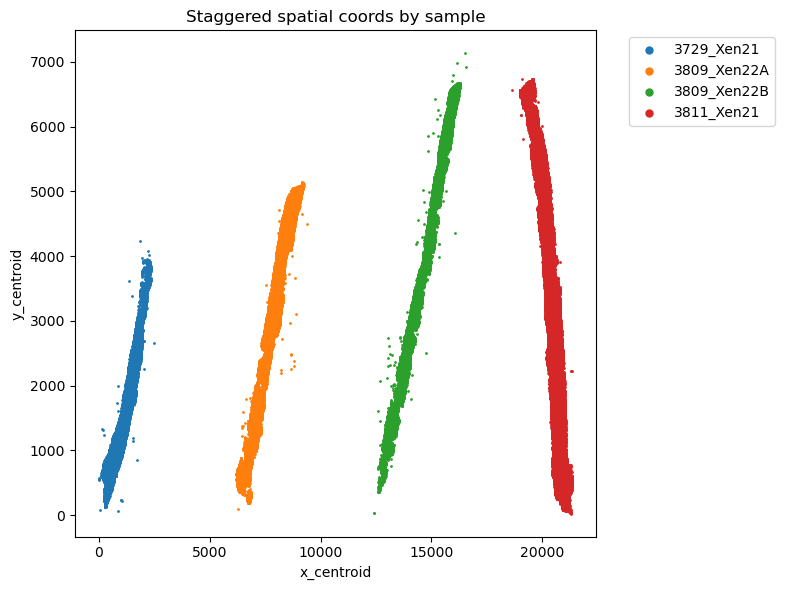

In [33]:
counts = adata.obs['sample'].value_counts().sort_index()
print("Cells per sample:")
print(counts)

# get min/max x after staggering
x_stats = adata.obs.groupby('sample')['x_centroid'].agg(['min','max'])
print("\nX‑coordinate range per sample (after staggering):")
print(x_stats)

# 3) quick scatter to visually confirm each sample’s “stripe”
fig, ax = plt.subplots(figsize=(8,6))
for sample in counts.index:
    sub = adata.obs[adata.obs['sample']==sample]
    ax.scatter(sub['x_centroid'], sub['y_centroid'], s=1, label=sample)
ax.legend(markerscale=5, bbox_to_anchor=(1.05,1), loc='upper left')
ax.set_title("Staggered spatial coords by sample")
ax.set_xlabel("x_centroid")
ax.set_ylabel("y_centroid")
plt.tight_layout()
plt.show()

In [34]:
from banksy_utils import filter_utils
from banksy.embed_banksy import convert2dense

# normalize
adata = filter_utils.normalize_total(adata)

--- Max-Min before normalization -----
Displaying max and min of Dataset
Max: 682.0, Min: 0.0

--- Max-Min after normalization -----
Displaying max and min of Dataset
Max: 78.0, Min: 0.0



In [35]:
# set all genes as HVGs
hvg_list = adata.var_names.tolist()  
# subset (does nothing if you use them all)
adata = adata[:, hvg_list]

In [36]:
from banksy.initialize_banksy import initialize_banksy
coord_keys = ('x_centroid', 'y_centroid', 'coord_xy')
nbr_weight_decay = 'scaled_gaussian'
k_geom = 18
x_centroid, y_centroid, xy_coord = coord_keys[0], coord_keys[1], coord_keys[2]

from banksy.main import concatenate_all
from banksy.embed_banksy import generate_banksy_matrix
resolutions = [0.70]
pca_dims = [20]
lambda_list = [0.5]
m = 1  # first order azimuthal transform

from banksy_utils.umap_pca import pca_umap
from banksy.cluster_methods import run_Leiden_partition
from banksy.plot_banksy import plot_results
c_map =  'tab20' # specify color map

In [37]:
print(adata.shape)

(71456, 300)


In [38]:
adata.obsm['coord_xy'] = np.vstack((adata.obs['x_centroid'].values, adata.obs['y_centroid'].values)).T 

In [39]:
print(adata.shape)

(71456, 300)


In [40]:
print(adata.obsm['coord_xy'].shape)
print(np.isnan(adata.obsm['coord_xy']).any())

(71456, 2)
False


In [41]:
print("Number of NaNs in x_centroid:", adata.obs['x_centroid'].isna().sum())
print("Number of NaNs in y_centroid:", adata.obs['y_centroid'].isna().sum())

Number of NaNs in x_centroid: 0
Number of NaNs in y_centroid: 0



Median distance to closest cell = 7.239235865707071

---- Ran median_dist_to_nearest_neighbour in 0.11 s ----

---- Ran generate_spatial_distance_graph in 0.32 s ----

---- Ran row_normalize in 0.09 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 0.99 s ----

----- Plotting Edge Histograms for m = 0 -----

Edge weights (distances between cells): median = 19.400045757633006, mode = 10.998418542545155

---- Ran plot_edge_histogram in 0.03 s ----


Edge weights (weights between cells): median = 0.048552395653473315, mode = 0.025450368394872035

---- Ran plot_edge_histogram in 0.03 s ----

---- Ran generate_spatial_distance_graph in 0.52 s ----

---- Ran theta_from_spatial_graph in 0.29 s ----

---- Ran row_normalize in 0.09 s ----

---- Ran generate_spatial_weights_fixed_nbrs in 1.52 s ----

----- Plotting Edge Histograms for m = 1 -----

Edge weights (distances between cells): median = 27.69310905746433, mode = 20.35066703374404

---- Ran plot_edge_histogram in 0.04 s ----


Edg

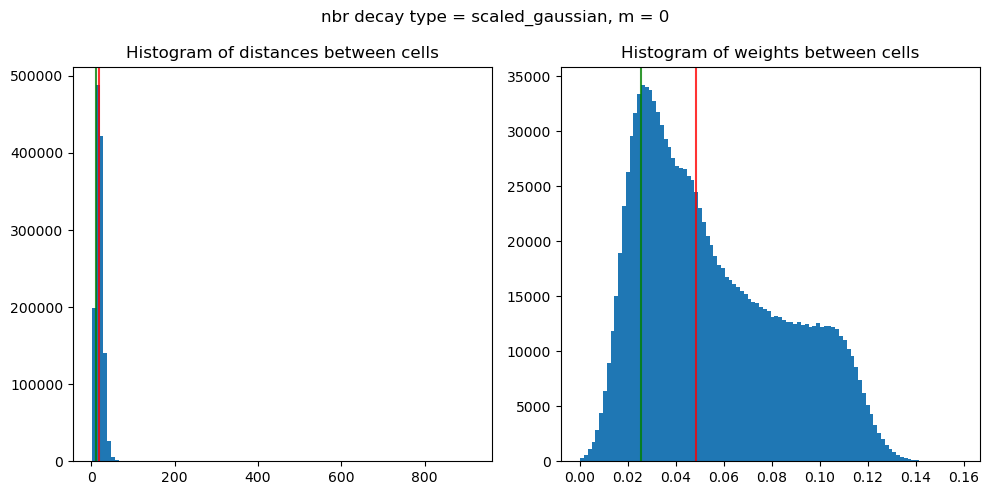

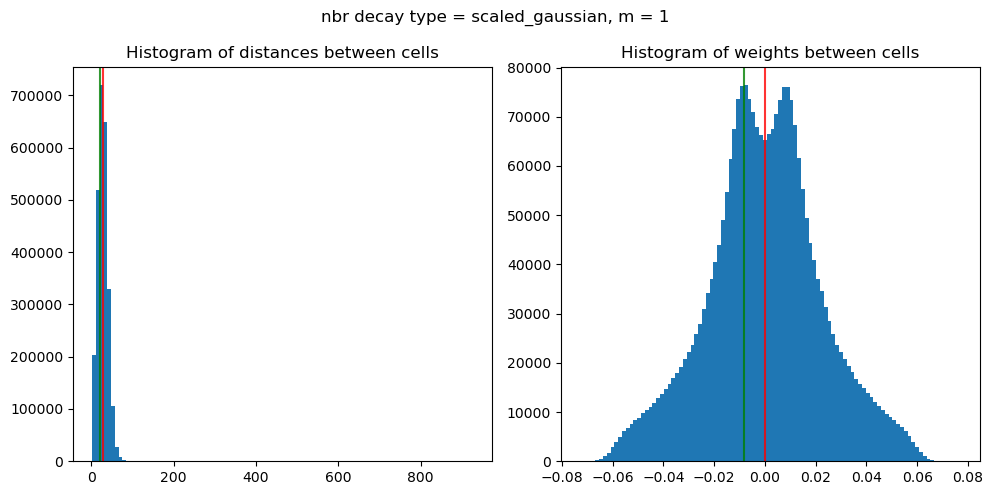

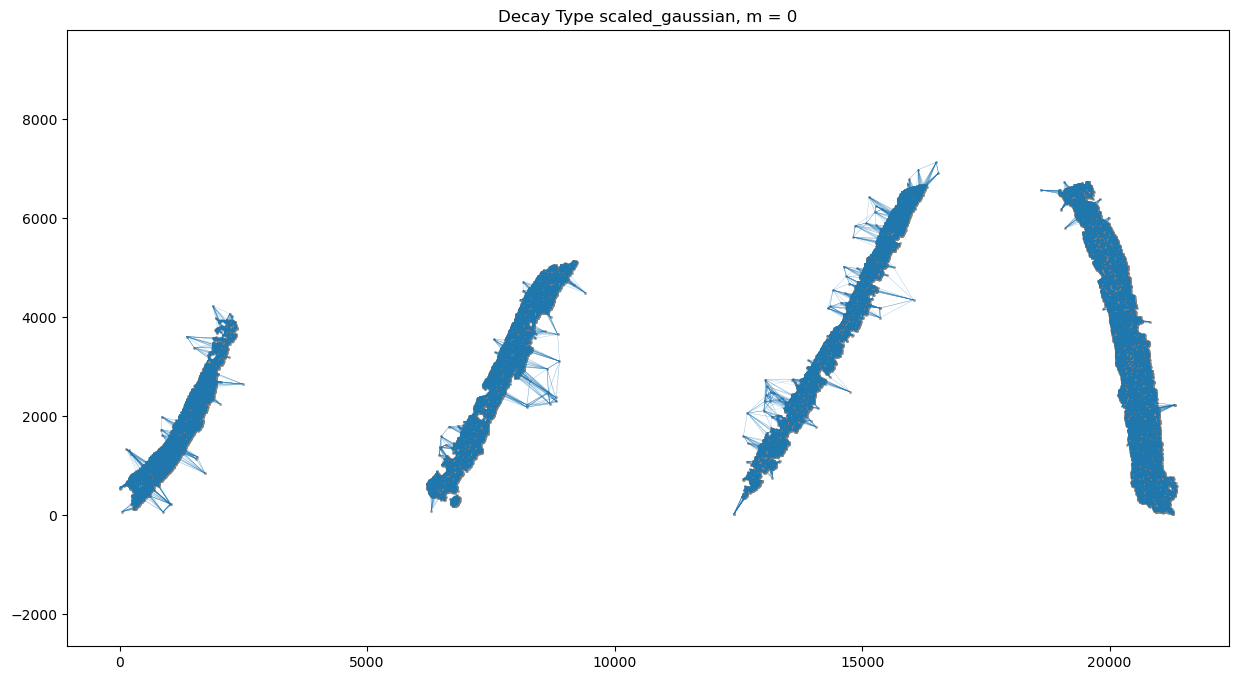

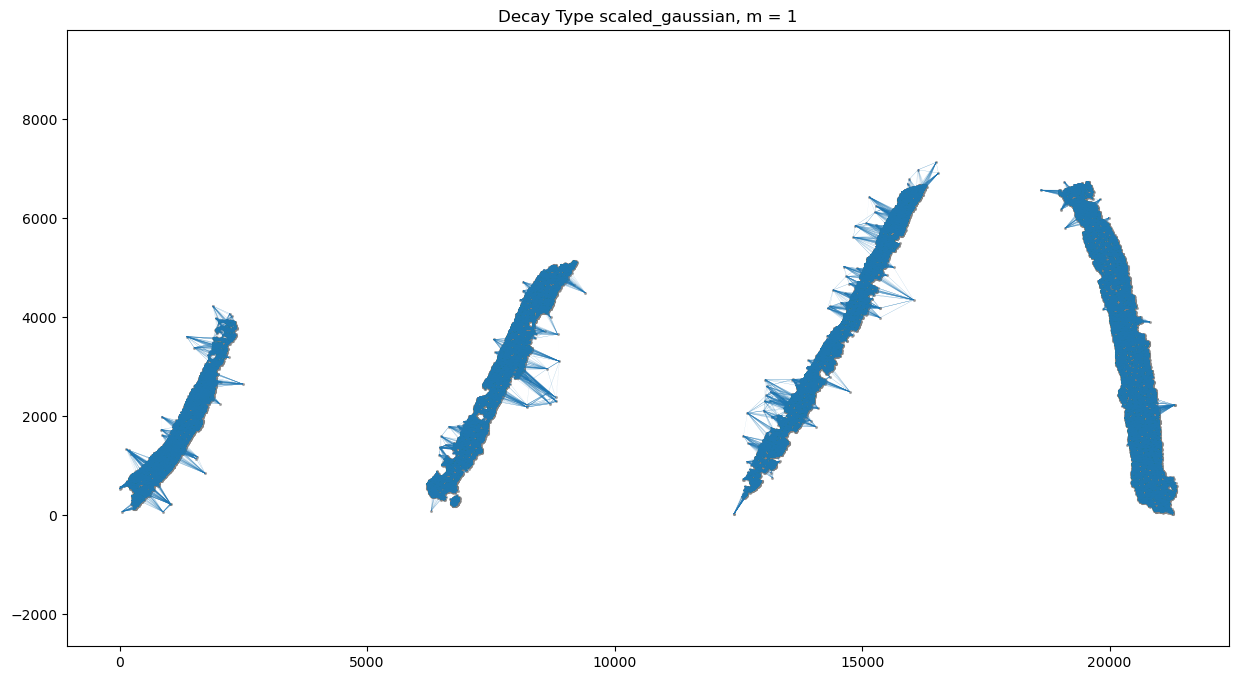

In [42]:
banksy_dict = initialize_banksy(adata,
                                coord_keys,
                                k_geom,
                                nbr_weight_decay=nbr_weight_decay,
                                max_m=m,
                                plt_edge_hist= True,
                                plt_nbr_weights= True,
                                plt_agf_angles=False,
                                plt_theta=False
                               )

banksy_dict, banksy_matrix = generate_banksy_matrix(adata,
                                                    banksy_dict,
                                                    lambda_list,
                                                    max_m=m)


banksy_dict["nonspatial"] = {
    # append nonspatial matrix (adata.X) to obtain the nonspatial clustering results
    0.0: {"adata": concatenate_all([adata.X], 0, adata=adata), }
}

print(banksy_dict['nonspatial'][0.0]['adata'])

Current decay types: ['scaled_gaussian', 'nonspatial']

Reducing dims of dataset in (Index = scaled_gaussian, lambda = 0.5)

Setting the total number of PC = 20
Original shape of matrix: (71456, 900)
Reduced shape of matrix: (71456, 20)
------------------------------------------------------------
min_value = -17.976184949969944, mean = 1.3056182994472284e-15, max = 15.185886236680737


Reducing dims of dataset in (Index = nonspatial, lambda = 0.0)

Setting the total number of PC = 20
Original shape of matrix: (71456, 300)
Reduced shape of matrix: (71456, 20)
------------------------------------------------------------
min_value = -25.53322722834449, mean = -2.6251578907392863e-17, max = 45.8801532179638



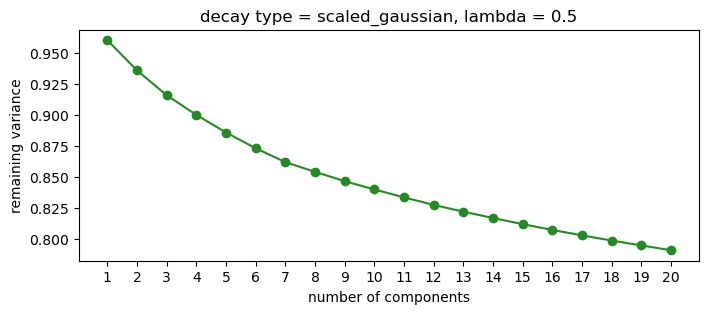

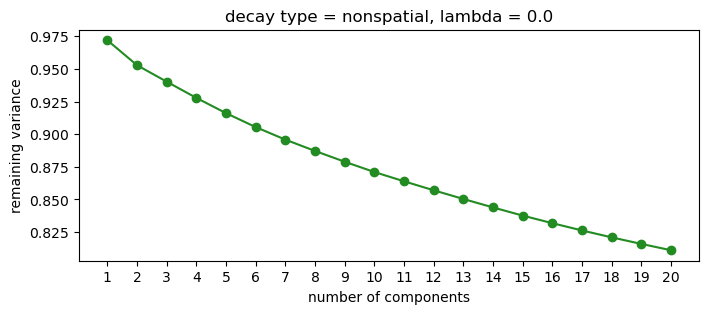

In [43]:
pca_umap(banksy_dict,
         pca_dims=pca_dims,
         add_umap=False
        )

In [44]:
!pip install harmony-pytorch

In [45]:
# batch correction with harmony
from harmony import harmonize
import umap

for pca_dim in pca_dims:
    # Run Harmony on PCA
    Z = harmonize(banksy_dict[nbr_weight_decay][0.5]["adata"].obsm[f'reduced_pc_{pca_dim}'], 
                  banksy_dict[nbr_weight_decay][0.5]["adata"].obs, batch_key = 'sample')
    
    print(f'Replacing adata.obsm["reduced_pc_{pca_dim}"] with harmony corrected embeddings.')
    banksy_dict[nbr_weight_decay][0.5]["adata"].obsm[f'reduced_pc_{pca_dim}'] = Z
    
    # Run UMAP
    reducer = umap.UMAP(transform_seed = 42)
    umap_embedding = reducer.fit_transform(Z)
    banksy_dict[nbr_weight_decay][0.5]["adata"].obsm[f"reduced_pc_{pca_dim}_umap"] = umap_embedding

	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
Reach convergence after 7 iteration(s).
Replacing adata.obsm["reduced_pc_20"] with harmony corrected embeddings.


In [46]:
# clustering 
from banksy.cluster_methods import run_Leiden_partition

results_df, max_num_labels = run_Leiden_partition(
    banksy_dict,
    resolutions,
    num_nn = 50,
    num_iterations = -1,
    partition_seed = 1234,
    match_labels = True,
)

Decay type: scaled_gaussian
Neighbourhood Contribution (Lambda Parameter): 0.5
reduced_pc_20 

reduced_pc_20_umap 

PCA dims to analyse: [20]

Setting up partitioner for (nbr decay = scaled_gaussian), Neighbourhood contribution = 0.5, PCA dimensions = 20)


Nearest-neighbour weighted graph (dtype: float64, shape: (71456, 71456)) has 3572800 nonzero entries.
---- Ran find_nn in 29.48 s ----


Nearest-neighbour connectivity graph (dtype: int16, shape: (71456, 71456)) has 3572800 nonzero entries.

(after computing shared NN)
Allowing nearest neighbours only reduced the number of shared NN from 70415978 to 3565357.


Shared nearest-neighbour (connections only) graph (dtype: int16, shape: (71456, 71456)) has 3348086 nonzero entries.

Shared nearest-neighbour (number of shared neighbours as weights) graph (dtype: int16, shape: (71456, 71456)) has 3348086 nonzero entries.

sNN graph data:
[22 11 10 ...  8  5  8]

---- Ran shared_nn in 1.98 s ----


-- Multiplying sNN connectivity by weights -

decay  lambda_param  num_pcs  \
nonspatial_pc20_nc0.00_r0.70            nonspatial           0.0       20   
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
nonspatial_pc20_nc0.00_r0.70              0.7          20   
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
nonspatial_pc20_nc0.00_r0.70       Label object:\nNumber of labels: 20, number of...   
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
nonspatial_pc20_nc0.00_r0.70       [[[View of AnnData object with n_obs × n_vars ...   
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
nonspatial_pc20_nc0.00_r0.70       Label object:\nNumber of labels: 20, number of...  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...

In [47]:
# plot clustering results
fig  = plt.figure(figsize=(12, 6) , constrained_layout=True)
grid = fig.add_gridspec(ncols=7, nrows=2) # modify based on expected output figure 

for counter, sample in enumerate(samples):
    for params_name in results_df.index:
        if params_name == 'scaled_gaussian_pc20_nc0.50_r0.40': 
            tmp_df = results_df
            tmp_label = tmp_df.loc[params_name, "labels"]
            tmp_adata = tmp_df.loc[params_name, "adata"].copy()

            # If label information is not stored in anndata object 
            tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
            adata_plt_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
            
            # plot refined spatial plot
            ax_locs1 = fig.add_subplot(grid[0, counter])
            scatterplot = ax_locs1.scatter(adata_plt_temp.obs[coord_keys[0]],
                                          adata_plt_temp.obs[coord_keys[1]],
                                          c=adata_plt_temp.obs['labels_' + params_name],
                                          cmap=c_map,
                                          vmin=0, vmax=max_num_labels - 1,
                                          s=3, alpha=1.0)
            ax_locs1.set_aspect('equal', 'datalim')
            ax_locs1.set_title(f'BANKSY {sample} Labels', fontsize=8, fontweight="bold", )

<Figure size 1200x600 with 0 Axes>

In [48]:
# compute ARI
ari = []
num_clus = []
sample_series = []
index_series = []

for counter, sample in enumerate(samples):
    for params_name in results_df.index:
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()

    
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
        adata_ari_temp.obs["manual_annotations"] = adata_ari_temp.obs["manual_annotations"].astype("category") # convert to categorical data for ARI computation

        ari.append(calc_ari(adata_ari_temp, "manual_annotations", 'labels_' + params_name))
        num_clus.append(results_df.loc[params_name, "num_labels"])
        sample_series.append(sample)
        index_series.append(params_name)

ari_df = pd.DataFrame(ari)
ari_df['num_labels'] = num_clus
ari_df['sample'] = sample_series
ari_df['df_index'] = index_series

# plot results
target_params = ['scaled_gaussian_pc20_nc0.50_r0.40']

fig  = plt.figure(figsize=(12,8), constrained_layout=True)
grid = fig.add_gridspec(ncols=3, nrows=2)

for counter, sample in enumerate(samples):
    for counter2, params_name in enumerate(target_params):
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()
        
        # assign cluster labels to tmp_adata.obs before subsetting
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)
        
        # subset data based on sample
        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]
        
        # extract ARI score
        print_ari = ari_df[
            (ari_df['sample'] == sample) & 
            (ari_df['df_index'].str.contains(params_name))
        ][0].values[0]
       
        # plot spatial location
        ax_locs1 = fig.add_subplot(grid[counter2*2, counter])
        weights_graph =  banksy_dict['scaled_gaussian']['weights'][0]
        scatterplot = ax_locs1.scatter(
            adata_ari_temp.obs[coord_keys[0]],
            adata_ari_temp.obs[coord_keys[1]],
            c=adata_ari_temp.obs['labels_' + params_name],
            cmap=c_map,
            vmin=0, vmax=max_num_labels - 1,
            s=3, alpha=1.0
        )
        ax_locs1.set_aspect('equal')
        ax_locs1.set_title(f'BANKSY {sample} Labels ARI= {print_ari:.5f}', fontsize=8, fontweight="bold")
        
        # plot umap
        ax_locs2 = fig.add_subplot(grid[1+counter2*2, counter])
        scatterplot = ax_locs2.scatter(
            adata_ari_temp.obsm['reduced_pc_20_umap'][:,0],
            adata_ari_temp.obsm['reduced_pc_20_umap'][:,1],
            c=adata_ari_temp.obs['labels_' + params_name],
            cmap=c_map,
            s=3, alpha=1.0
        )
        ax_locs2.set_aspect('equal')
        ax_locs2.set_title(f'BANKSY {sample} ({params_name})', fontsize=6, fontweight="bold")


In [49]:
# add cluster info to adata.obs
params_name = 'scaled_gaussian_pc20_nc0.50_r0.70'  

if params_name in results_df.index:
    # extract cluster labels
    cluster_labels = results_df.loc[params_name, 'labels'].dense 
    
    # assign to adata.obs
    adata.obs['banksy_clusters'] = cluster_labels
    print("Cluster assignments added to adata.obs")
else:
    print(f"Parameter set '{params_name}' not found in results_df")

Cluster assignments added to adata.obs


In [50]:
adata

AnnData object with n_obs × n_vars = 71456 × 300
    obs: 'x_centroid', 'y_centroid', 'cell_label', 'manual_annotations', 'sample', 'banksy_clusters'
    obsm: 'coord_xy'

Crosstab of Cell Types vs. BANKSY Clusters (Aggregated):
banksy_clusters   0   1   2   3   4    5   6   7   8    9   10  11  12    13  \
cell_label                                                                     
ATL               74   1   0  22  35    4   8   9   4  116  34   3   6     4   
B                 63   1   0  11   5    2   7   8   0    0  64   2  95     1   
CNT               56   2   1  22   8  549  30  28   8   49  60  10  13   108   
DC               518   0   1  56   2   15  26  39   3    5  56   0  62     6   
DCT               72  15   3  28  15  110  20  58  42   29  92  10  13  1064   

banksy_clusters  14  
cell_label           
ATL               1  
B                 0  
CNT               9  
DC                0  
DCT              17  


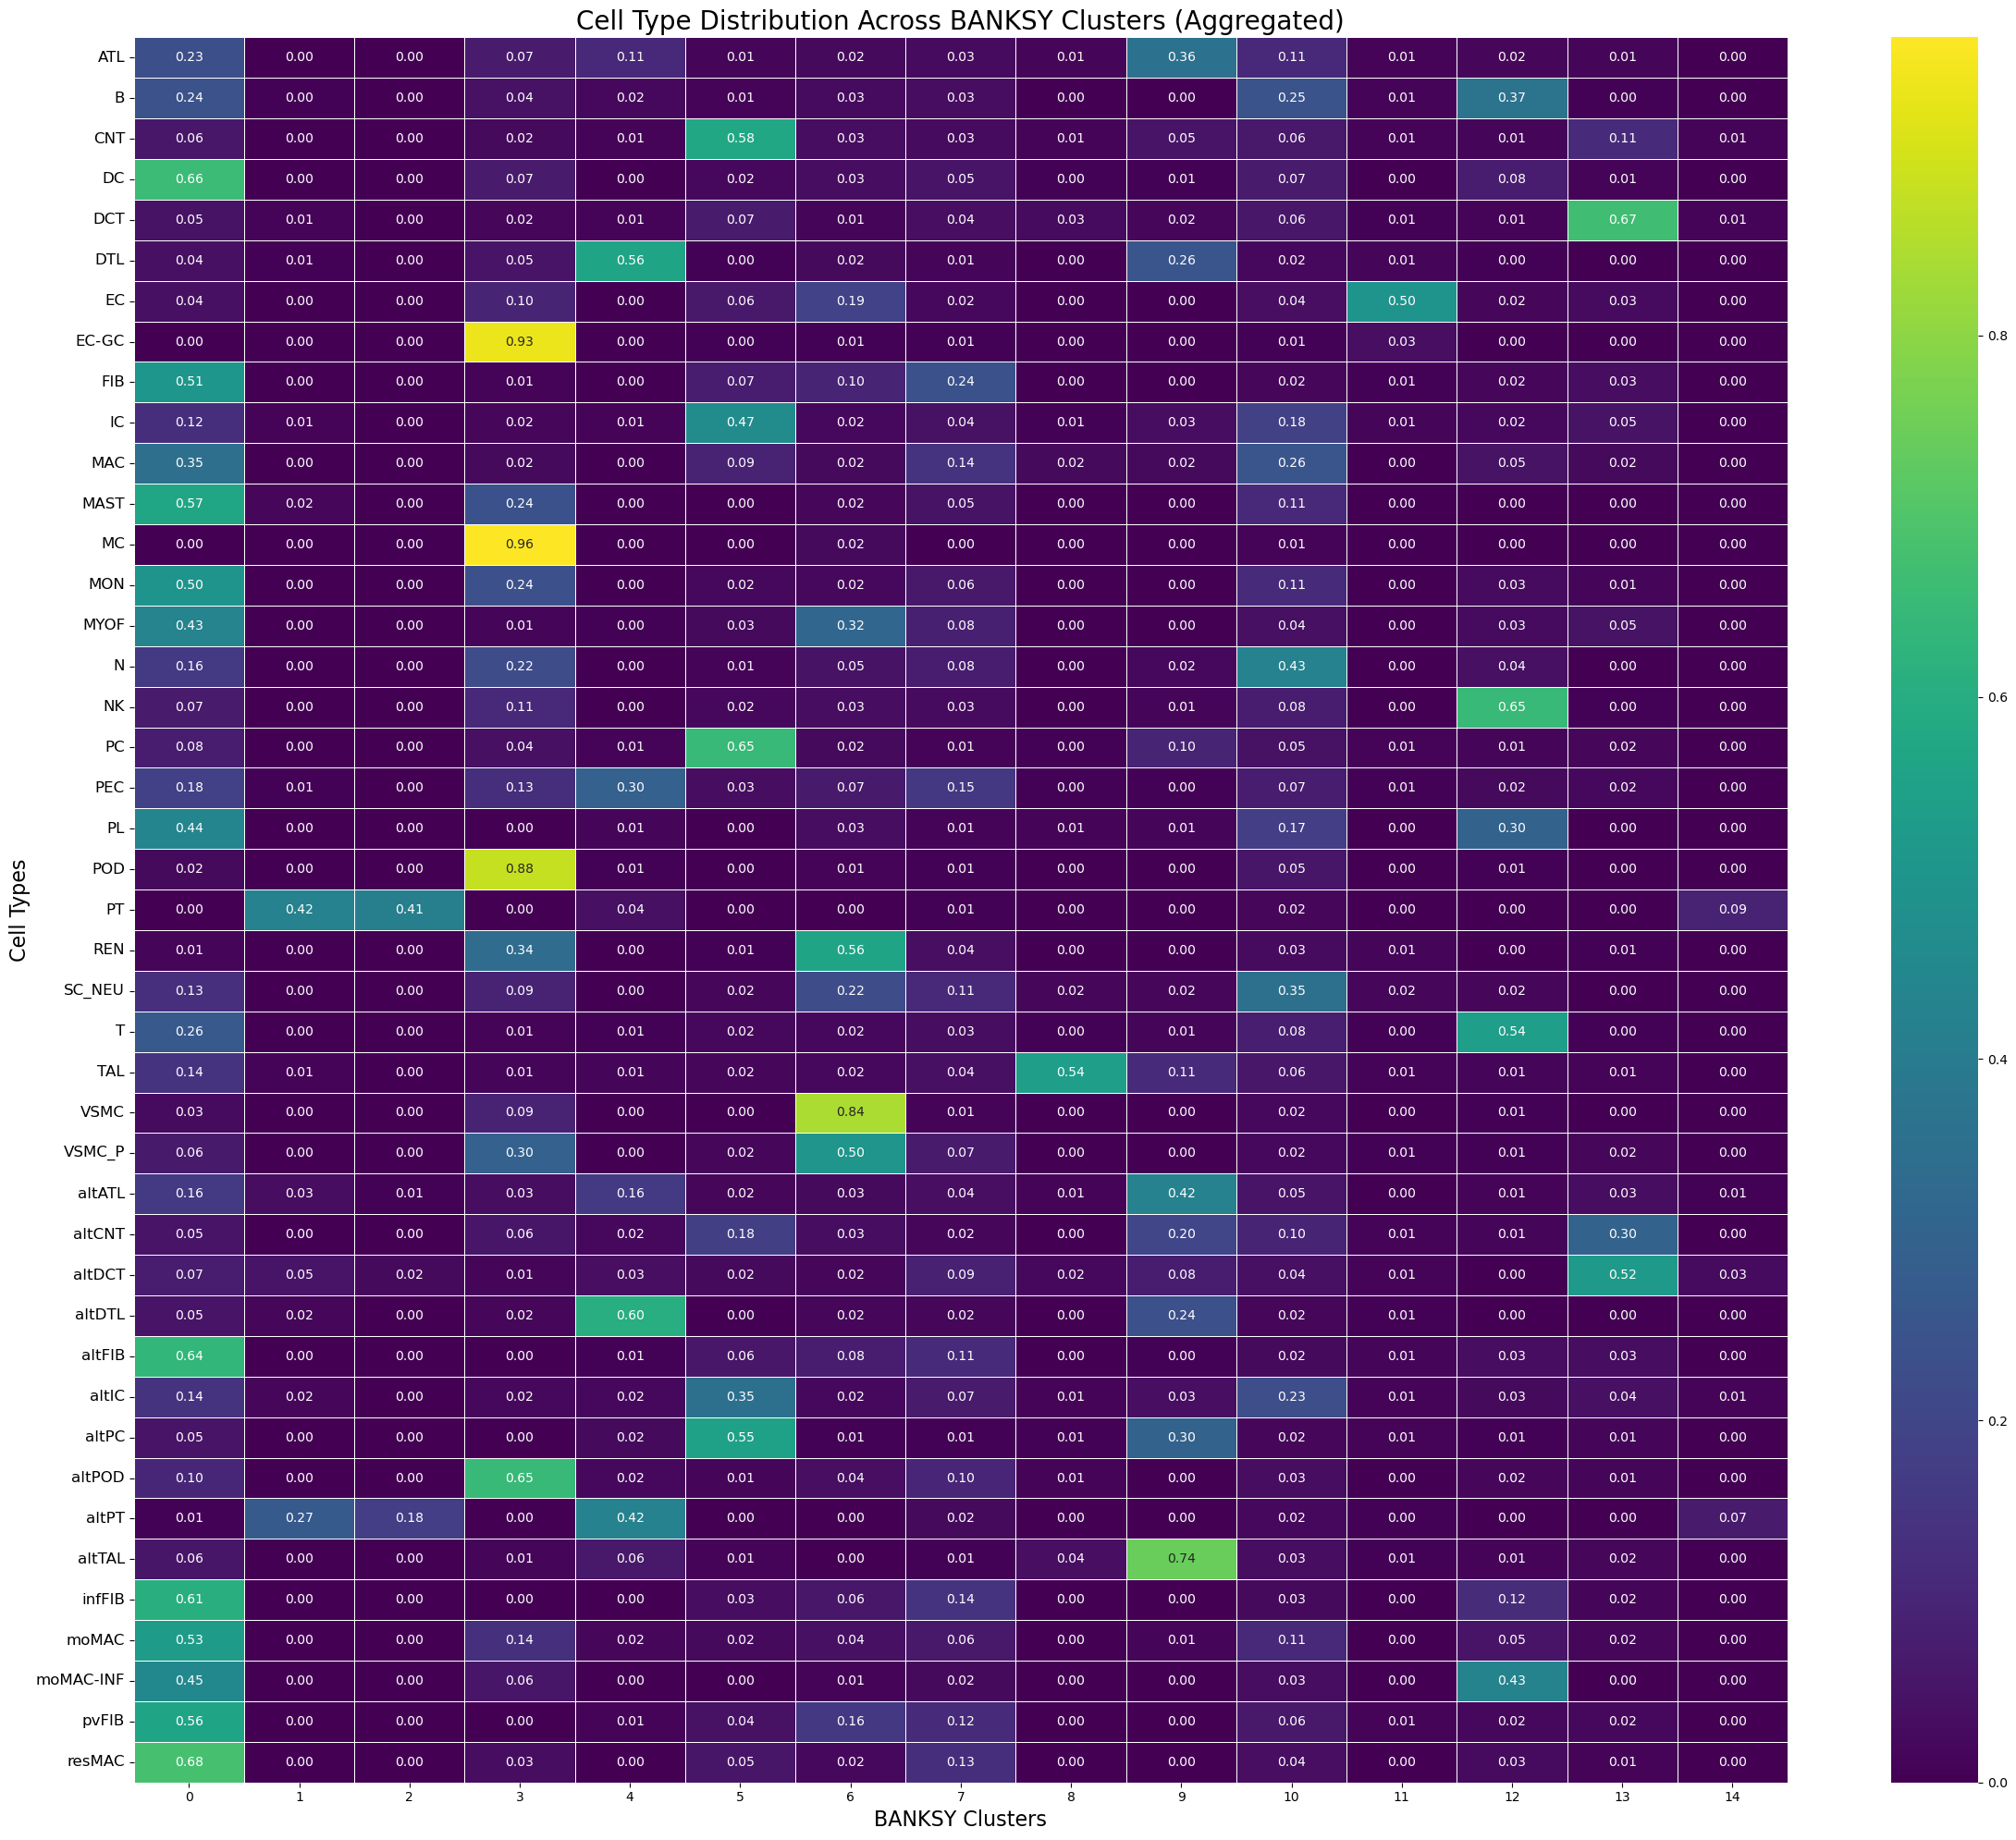

In [51]:
# create heatmap for cluster cell type
import seaborn as sns

cluster_col = 'banksy_clusters'  
cell_type_col = 'cell_label'  

# crosstab of cell types vs. clusters
crosstab = pd.crosstab(adata.obs[cell_type_col], adata.obs[cluster_col])

# display crosstab
print("Crosstab of Cell Types vs. BANKSY Clusters (Aggregated):")
print(crosstab.head())

# normalize crosstab by row to get proportions
crosstab_normalized = crosstab.div(crosstab.sum(axis=1), axis=0)

# plot heatmap
plt.figure(figsize=(24, 20))


ax = sns.heatmap(crosstab_normalized, cmap="viridis", annot=True, fmt=".2f", linewidths=0.5, yticklabels=crosstab_normalized.index)
plt.title('Cell Type Distribution Across BANKSY Clusters (Aggregated)', fontsize=20)
plt.xlabel('BANKSY Clusters', fontsize=16)
plt.ylabel('Cell Types', fontsize=16)

ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=12)
plt.tight_layout()

plt.savefig('/Volumes/Active/Xenium/Data/IntegratedST_Xenium_Data/LUNG_banksy/LUNG_cell_type_distribution_50.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [52]:
current_max_rows = pd.get_option('display.max_rows')
current_max_columns = pd.get_option('display.max_columns')

# display all rows and columns
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns

# display crosstab
crosstab = pd.crosstab(adata.obs['banksy_clusters'], adata.obs['sample'])
print("Crosstab of Clusters vs. Samples:")
print(crosstab)

# reset pandas display options to original values
pd.set_option('display.max_rows', current_max_rows)
pd.set_option('display.max_columns', current_max_columns)

Crosstab of Clusters vs. Samples:
sample           3729_Xen21  3809_Xen22A  3809_Xen22B  3811_Xen21
banksy_clusters                                                  
0                      3814         2209         2096        4691
1                       511         1813         1745        2664
2                       544         1220         1401        2649
3                      1273          758          646        2916
4                      1384          923         1035        1709
5                       585         1297         1182        1927
6                       926         1563         1271        1221
7                       621          755          890        1982
8                       301         1338         1685         797
9                       444         1038         1295         821
10                     1582          582          302        1087
11                      420          811          891        1429
12                      828          375  

In [53]:
# normalize by row (cluster)
crosstab_normalized = crosstab.div(crosstab.sum(axis=1), axis=0)

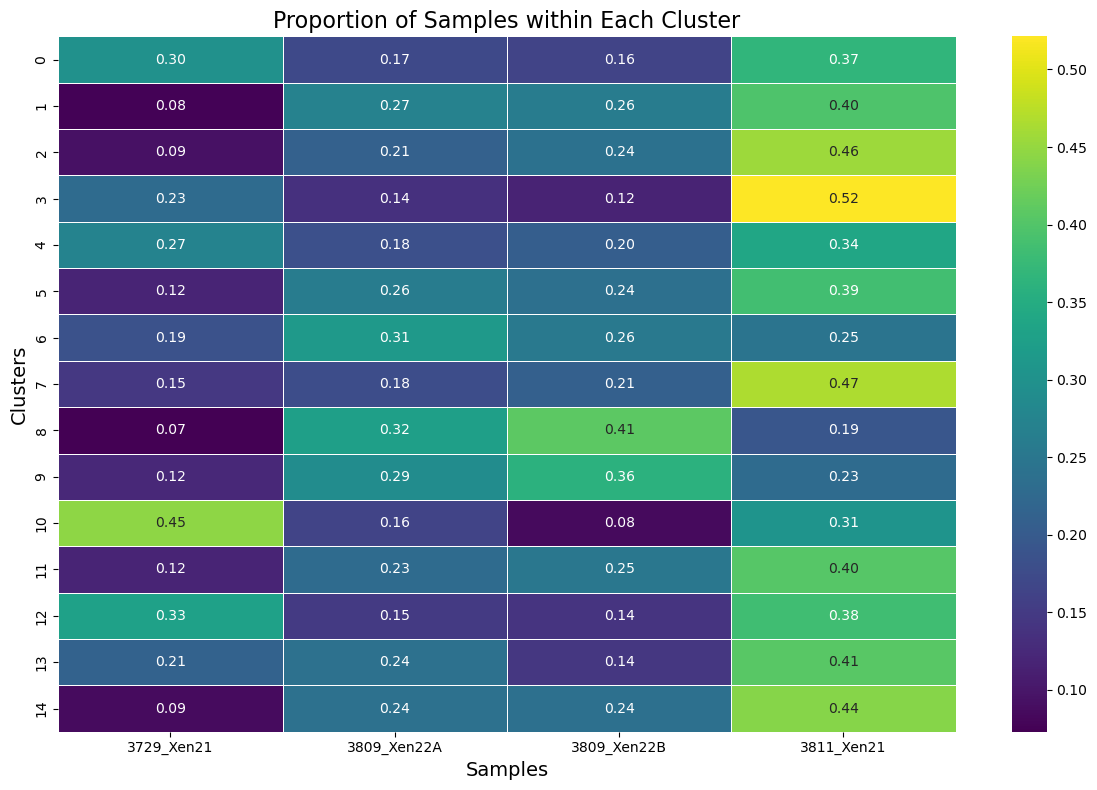

In [54]:
# Plot heatmap for normalized crosstab (proportion of samples within each cluster)
plt.figure(figsize=(12, 8))
sns.heatmap(
    crosstab_normalized,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    linewidths=0.5
)
plt.title('Proportion of Samples within Each Cluster', fontsize=16)
plt.xlabel('Samples', fontsize=14)
plt.ylabel('Clusters', fontsize=14)
plt.tight_layout()
plt.savefig('/Volumes/Active/Xenium/Data/IntegratedST_Xenium_Data/LUNG_banksy/cluster_sample_proportion_heatmap.pdf', format='pdf', bbox_inches='tight')
plt.show()



After sorting Dataframe
Shape of dataframe: (1, 7)

Maximum number of labels = 15
Indices of sorted list: [0]

Expanding labels with ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14] so that ids range from 0 to 14

Label ids zerod: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14].
0 to be inserted between each id: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
0 extra rows to be randomly inserted: [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
New ids: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
---- Ran expand_labels in 0.00 s ----


Matched Labels


decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...

                                             decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...  
number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----


decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...

                                             decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...  
number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----


decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...

                                             decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...  
number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----


decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...

                                             decay  lambda_param  num_pcs  \
scaled_gaussian_pc20_nc0.50_r0.70  scaled_gaussian           0.5       20   

                                   resolution  num_labels  \
scaled_gaussian_pc20_nc0.50_r0.70         0.7          15   

                                                                              labels  \
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...   

                                                                               adata  \
scaled_gaussian_pc20_nc0.50_r0.70  [[[View of AnnData object with n_obs × n_vars ...   

                                                                           relabeled  
scaled_gaussian_pc20_nc0.50_r0.70  Label object:\nNumber of labels: 15, number of...  
number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----

number of labels: 15
---- Ran plot_2d_embeddings in 0.00 s ----


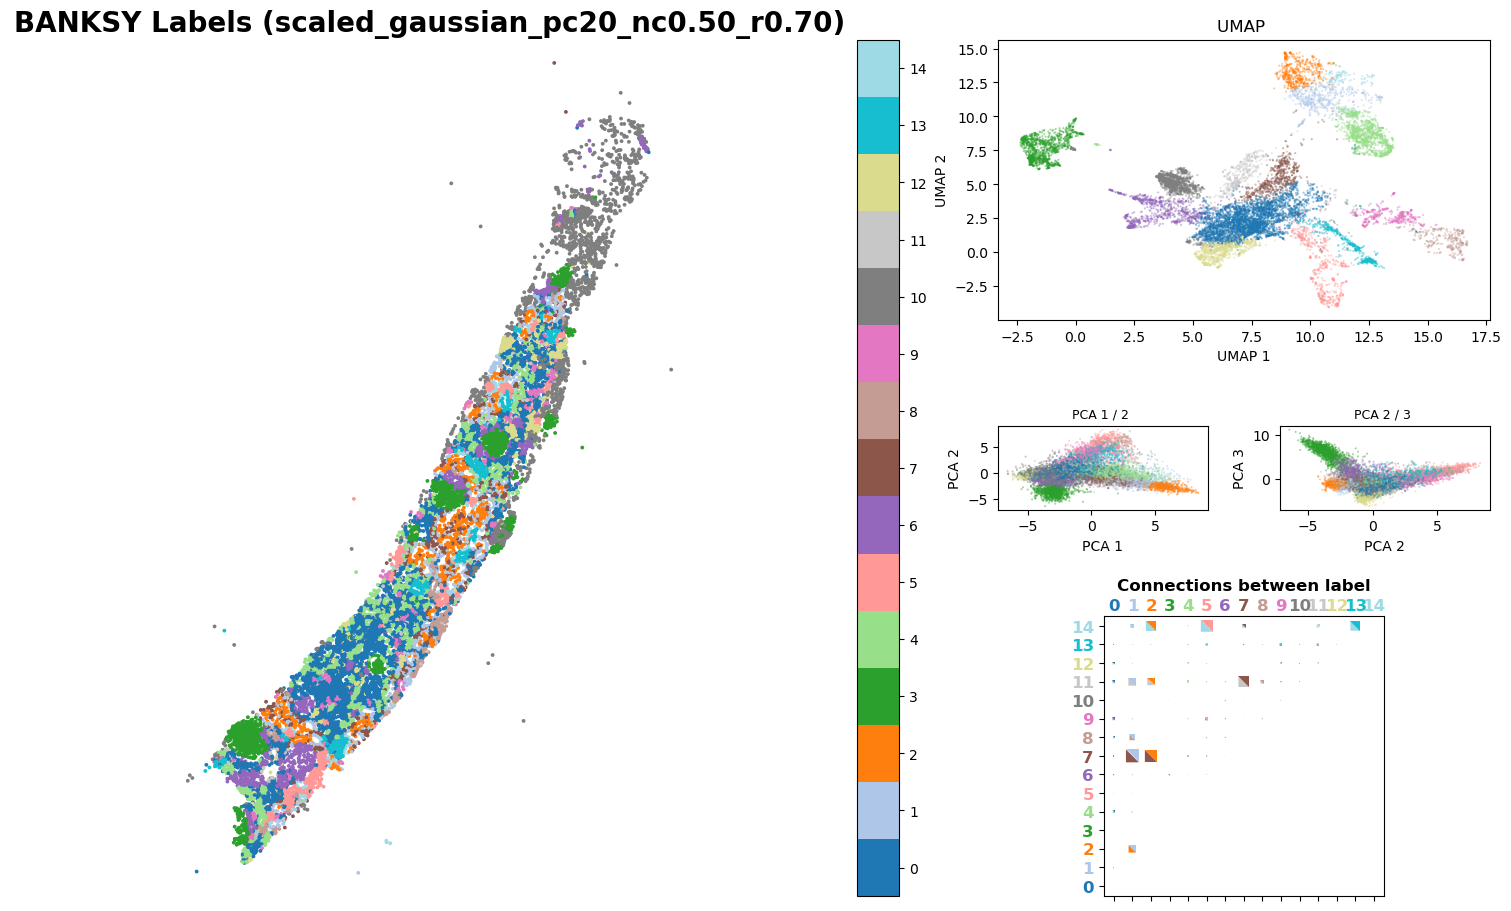

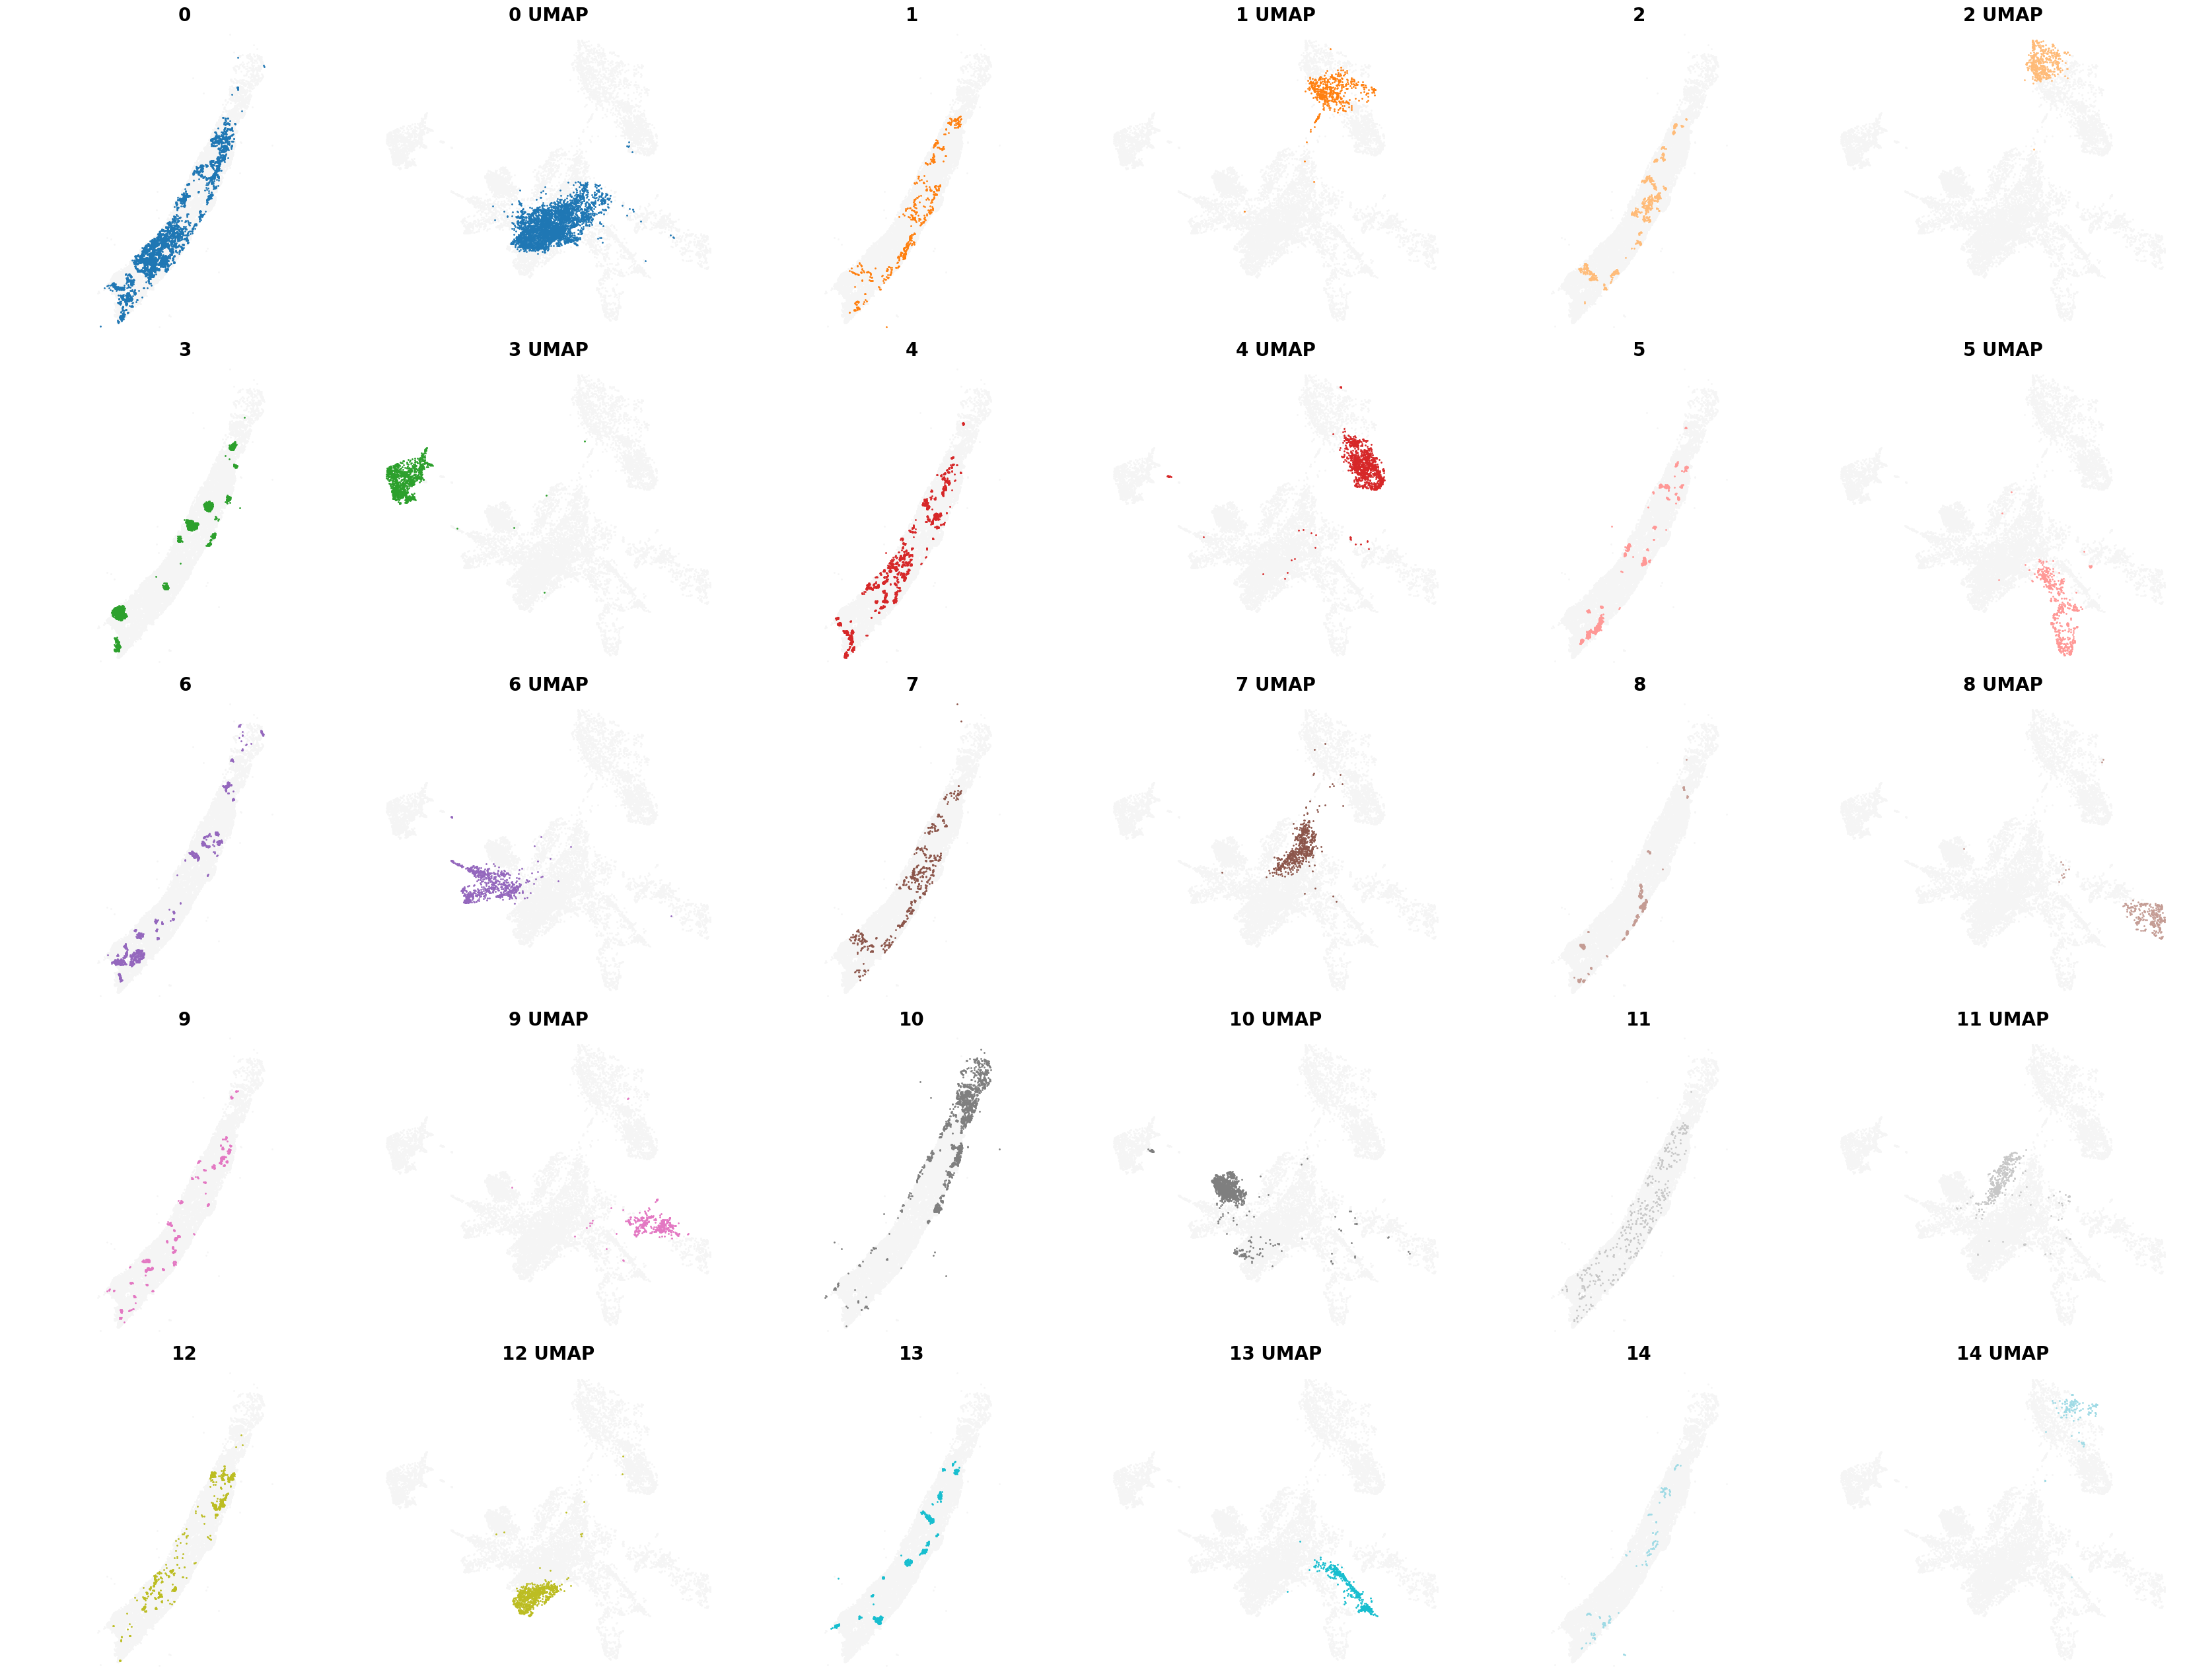

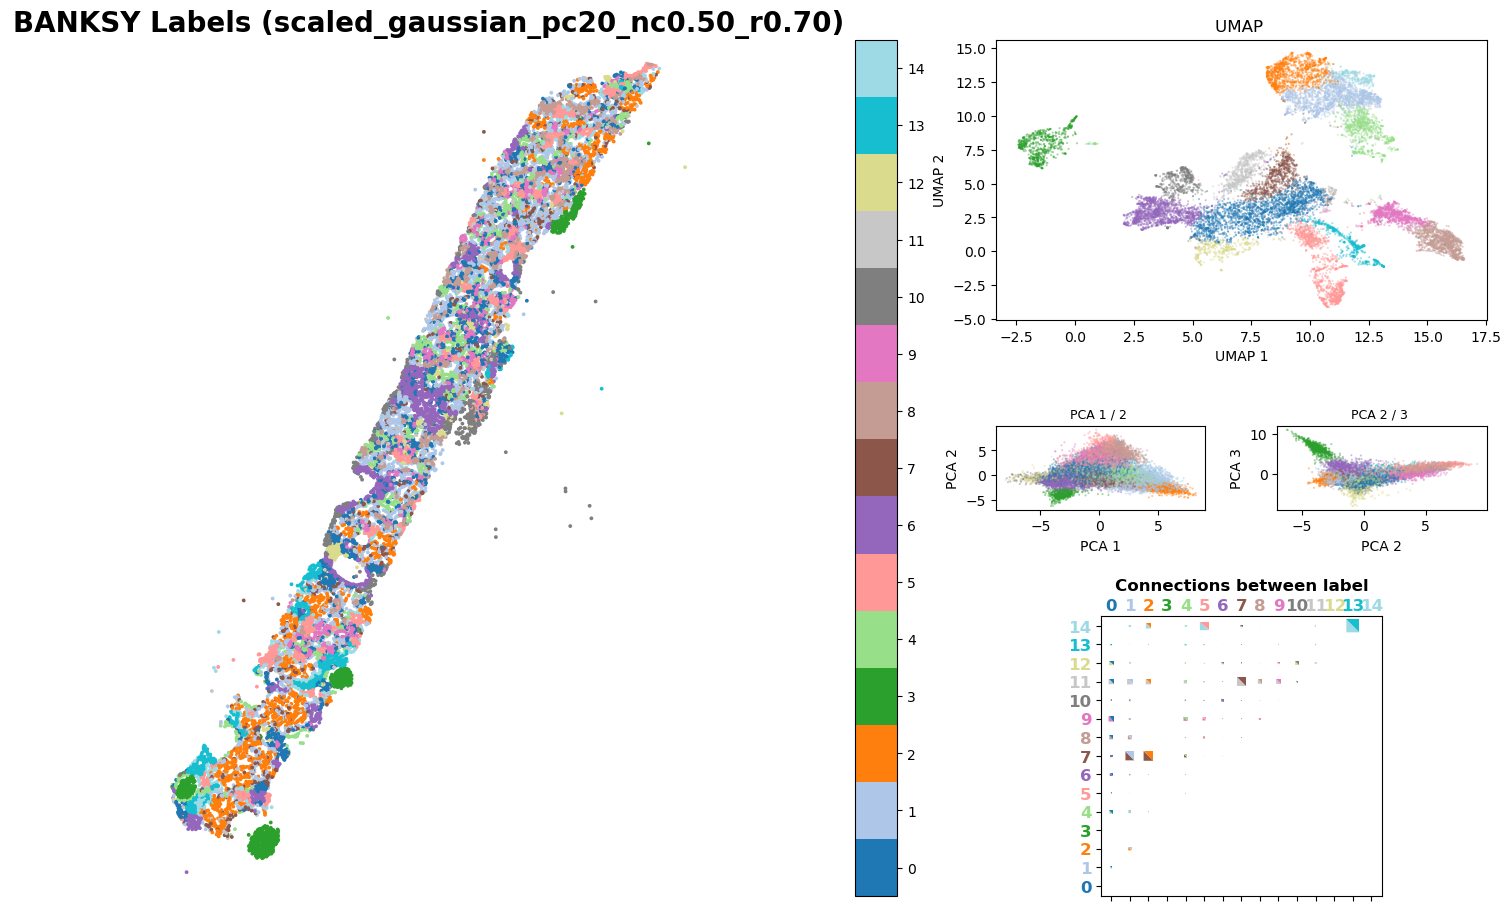

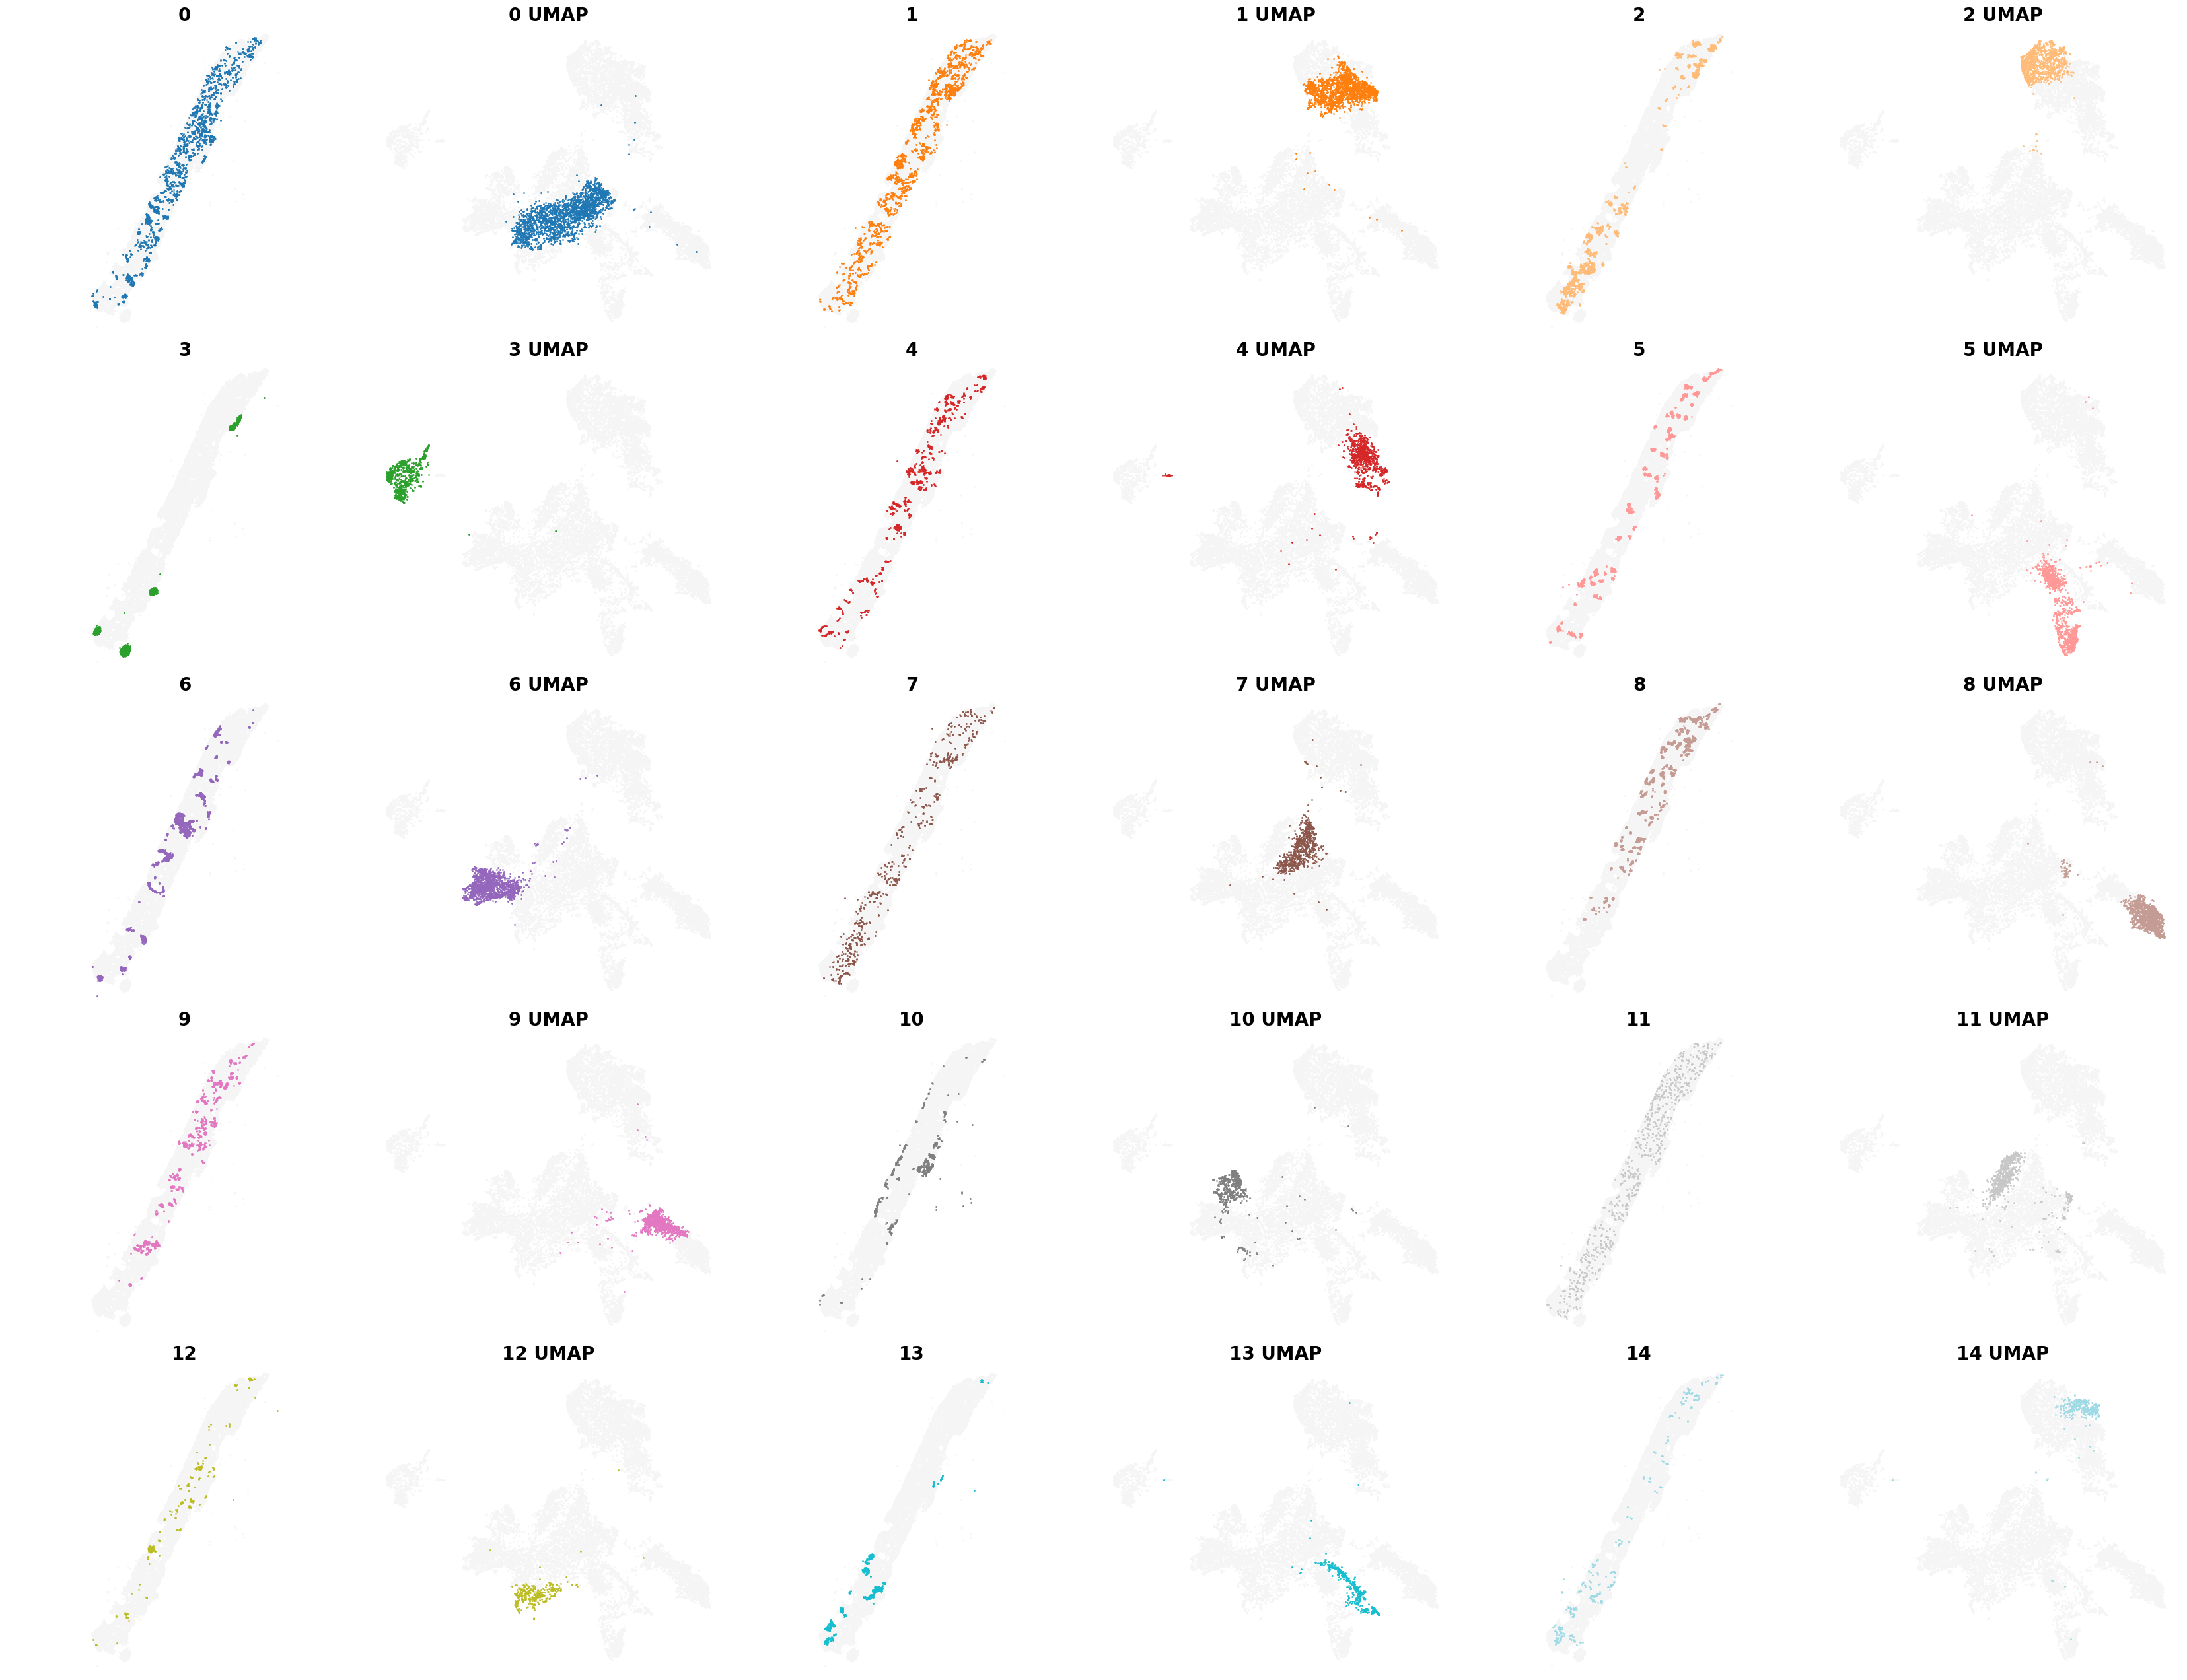

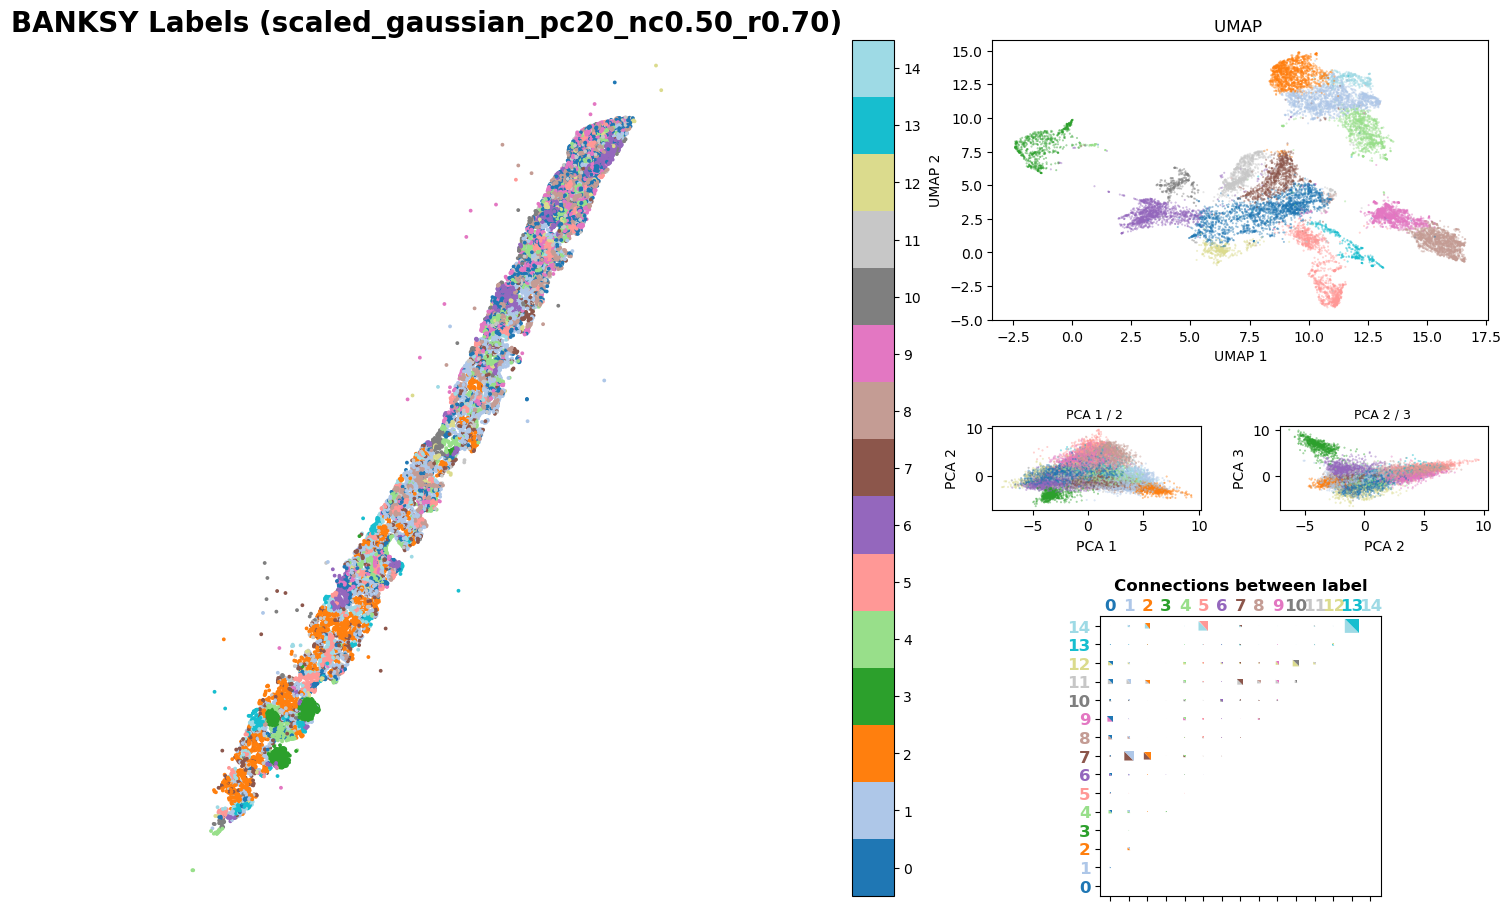

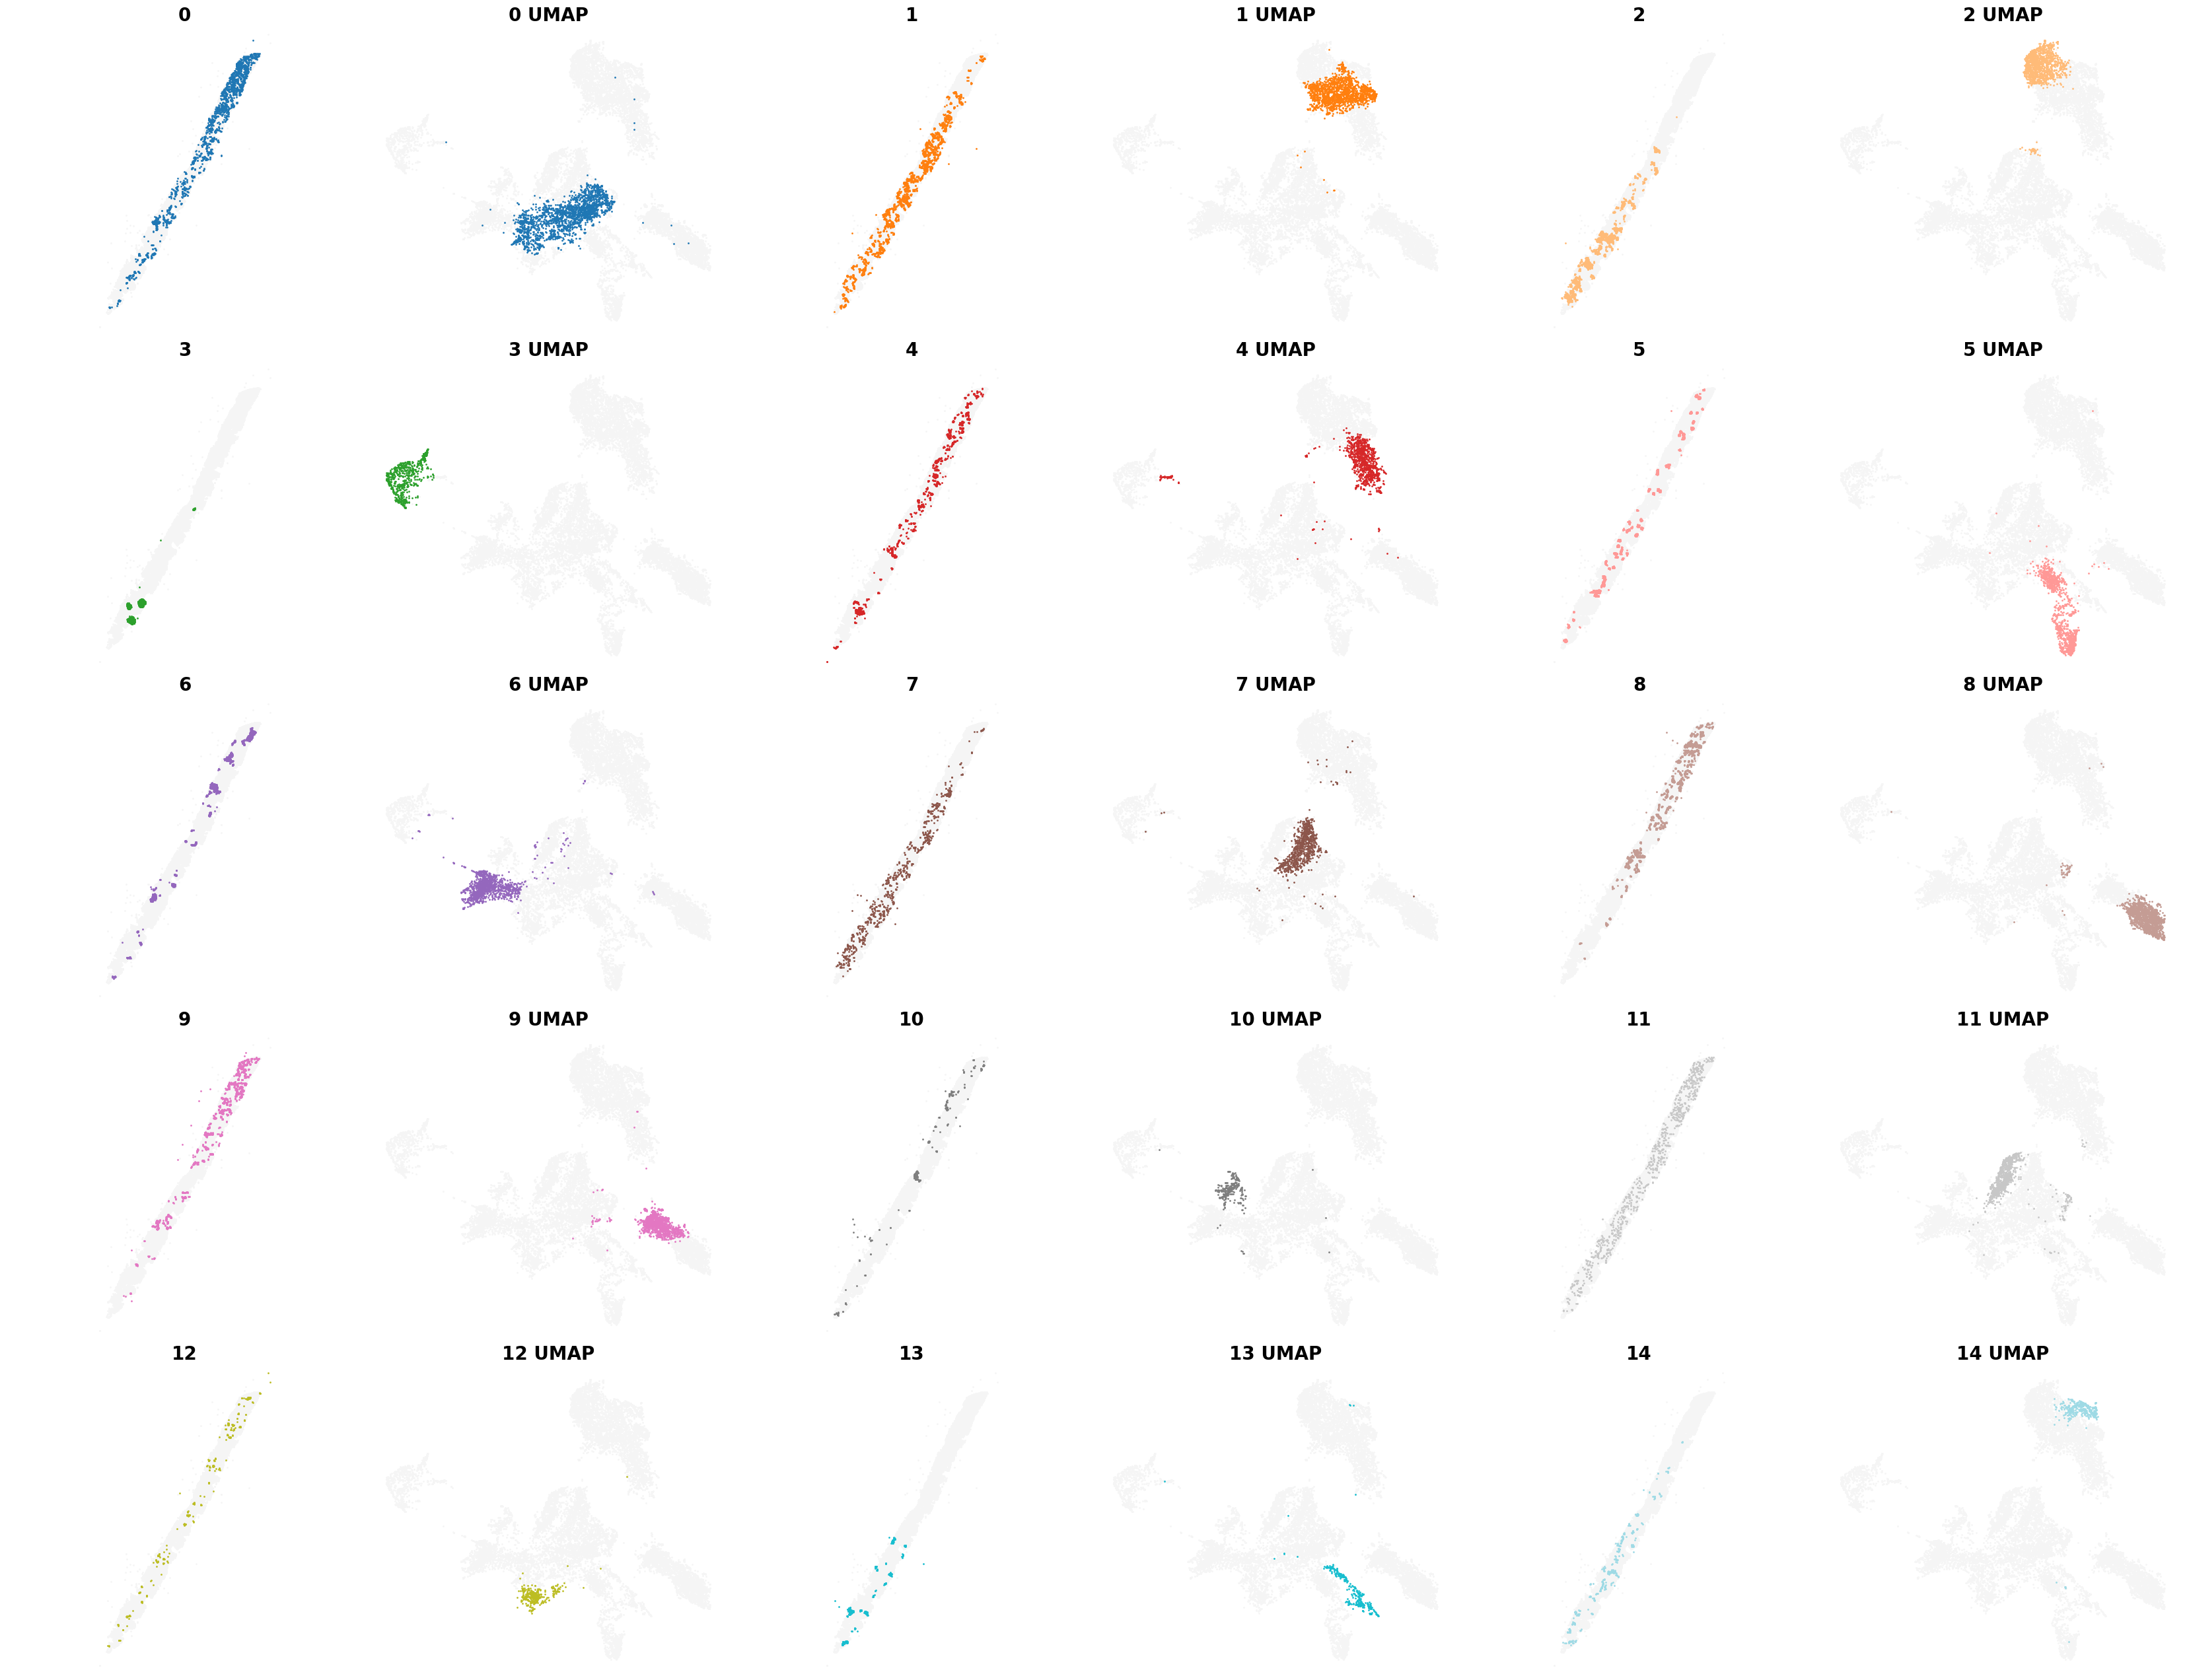

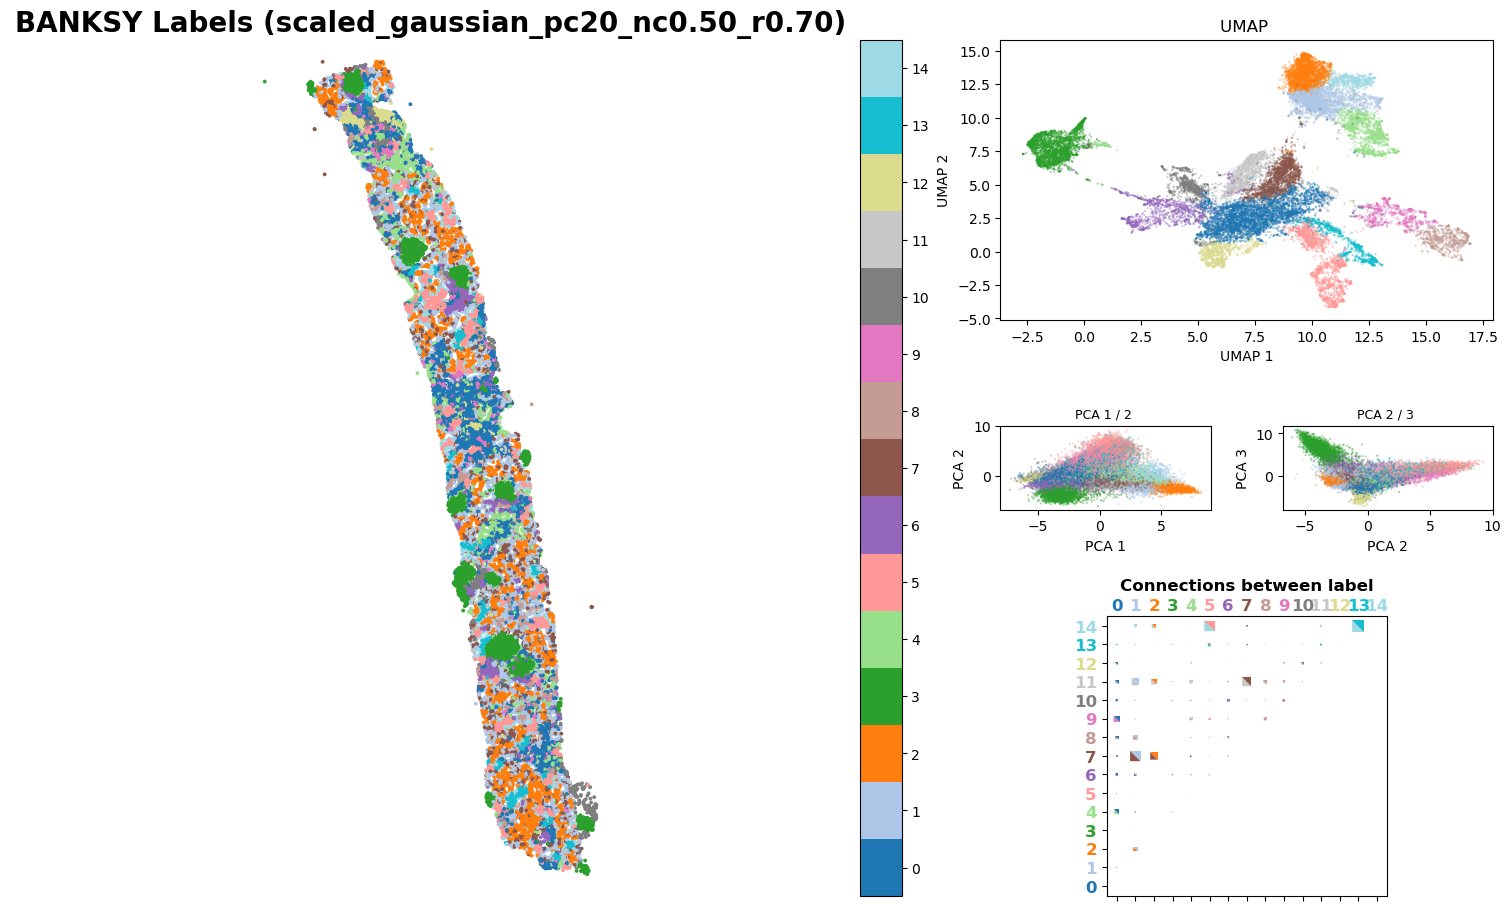

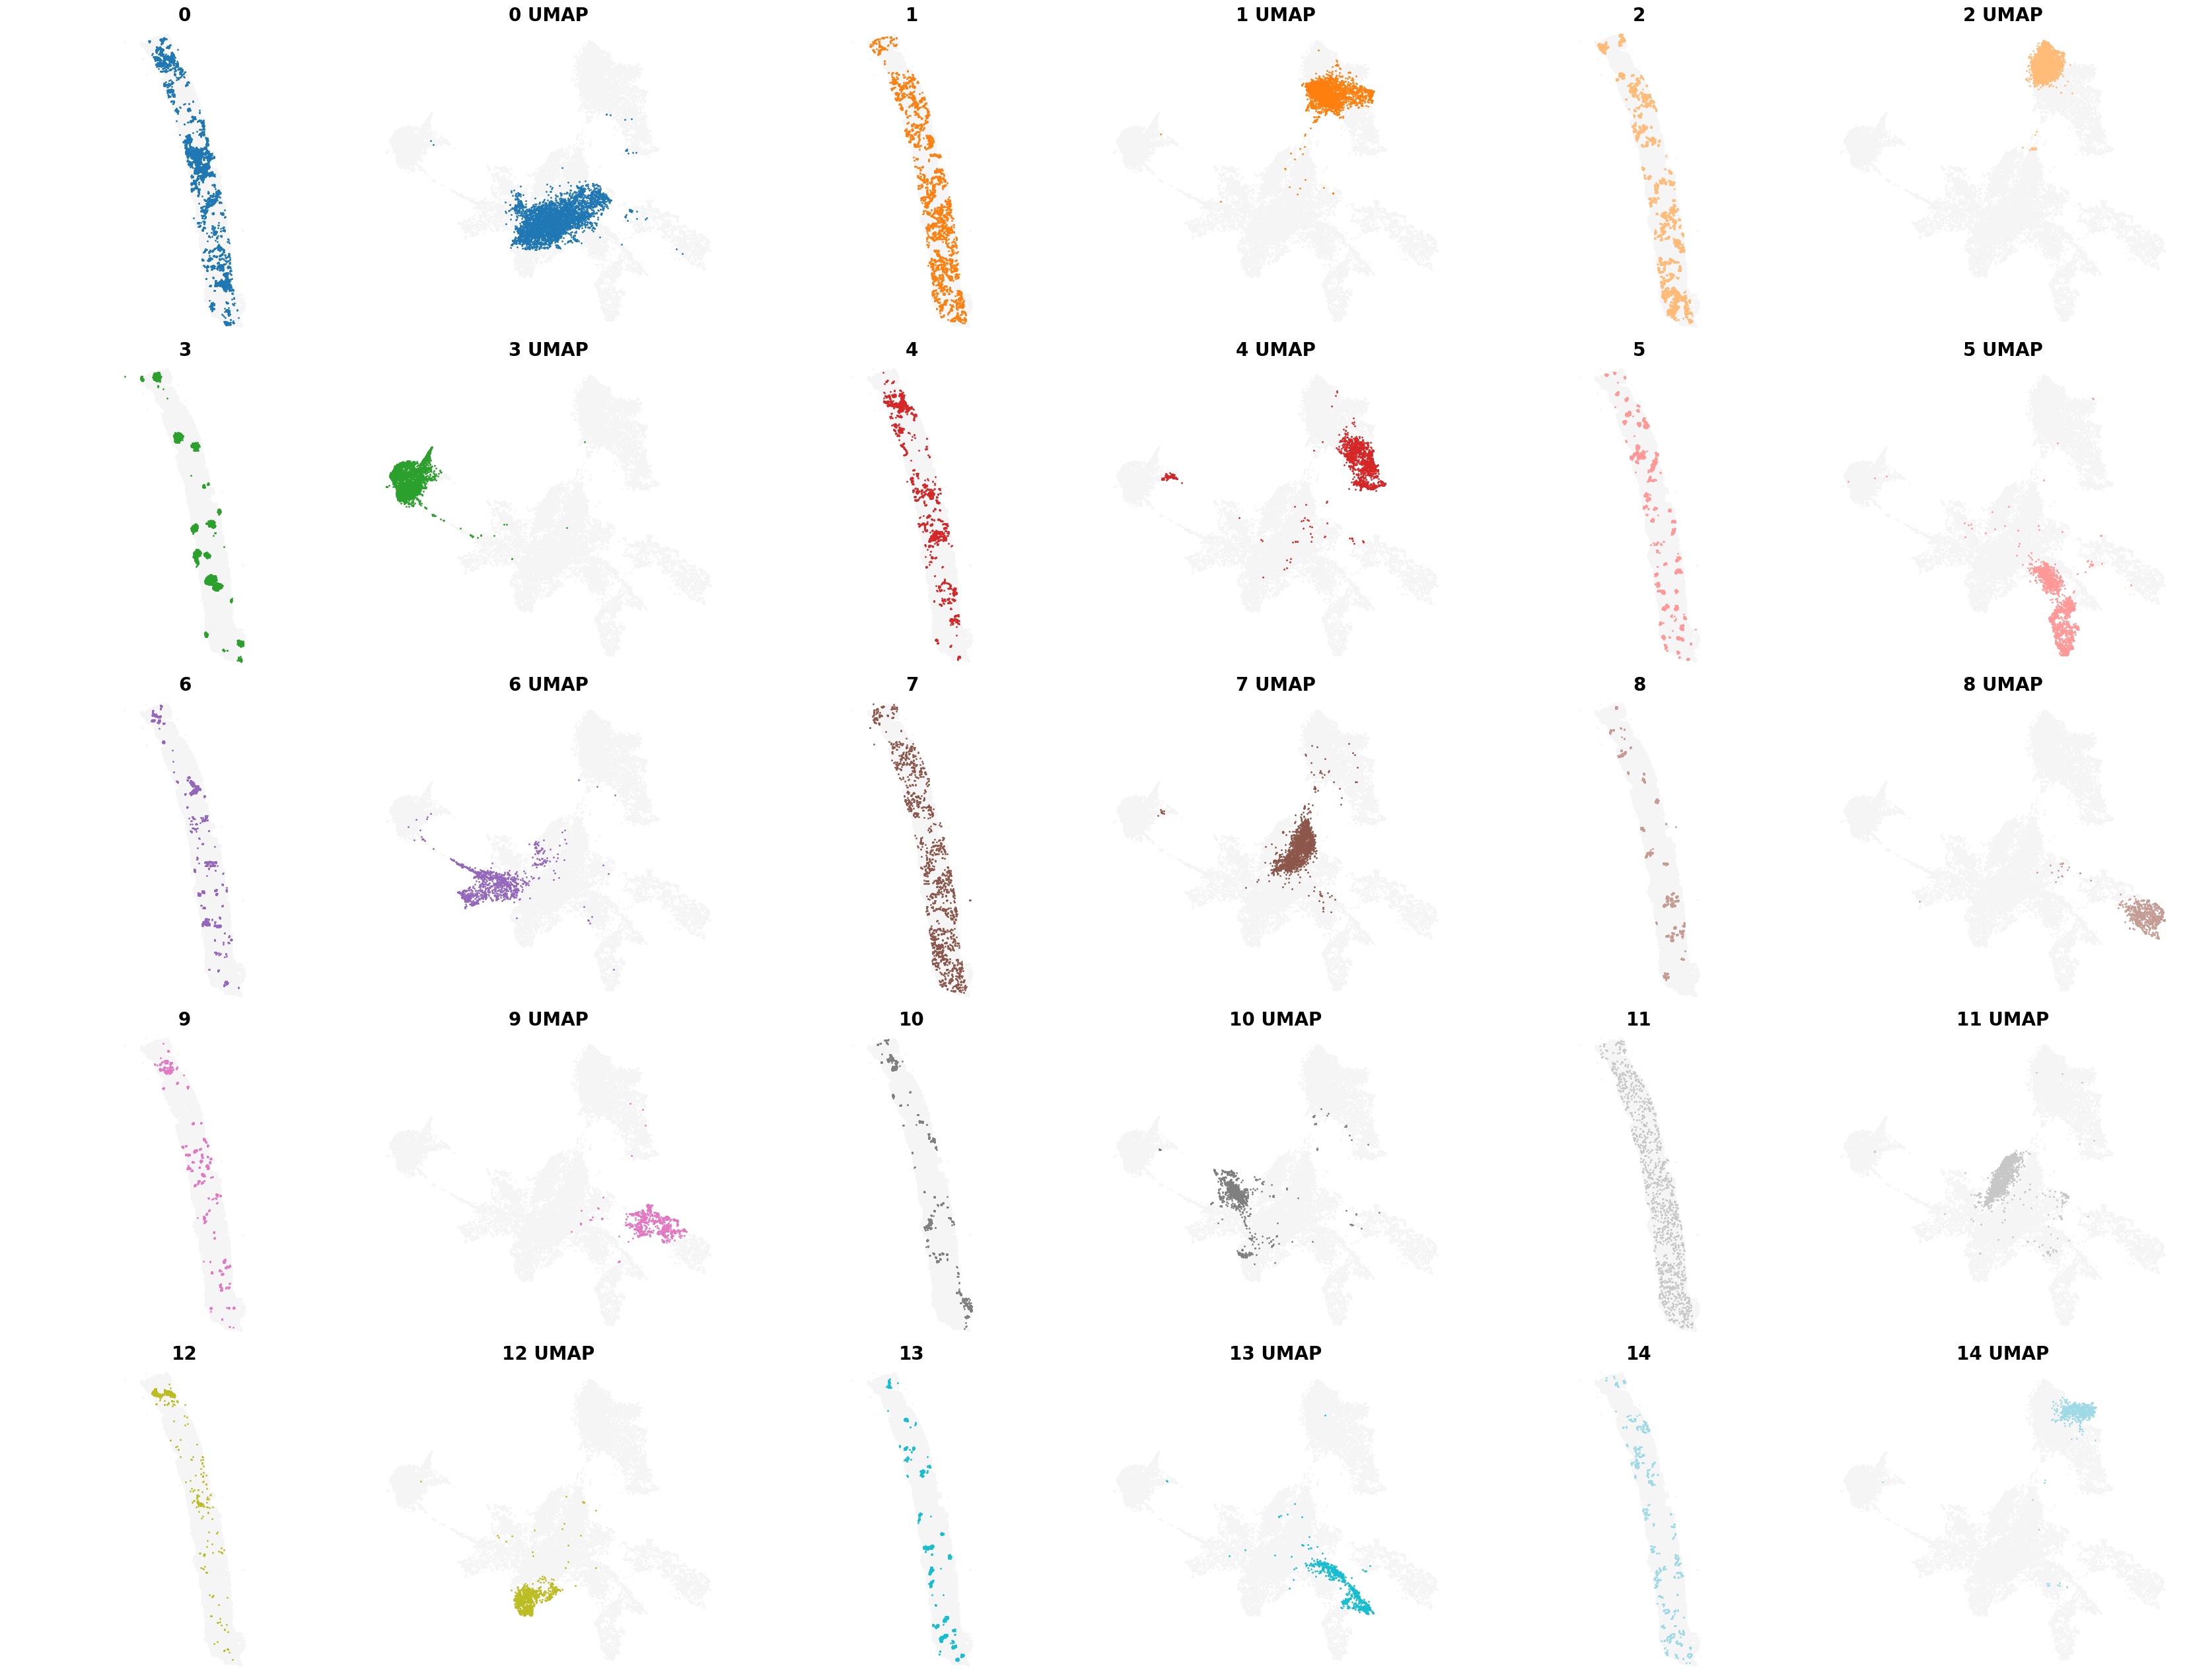

In [55]:
from banksy.plot_banksy import plot_results
from banksy.plot_banksy import plot_connections
from banksy.labels import Label
from banksy.cluster_methods import convert2df

target_params = ['scaled_gaussian_pc20_nc0.50_r0.70']

for counter, sample in enumerate(samples):
    for counter2, params_name in enumerate(target_params):
        # Get results from original results_df
        tmp_df = results_df
        tmp_label = tmp_df.loc[params_name, "labels"]
        tmp_adata = tmp_df.loc[params_name, "adata"].copy()
        
        # Add label information to adata
        tmp_adata.obs['labels_' + params_name] = pd.Categorical(tmp_label.dense)

        # Store weights in obsm
        tmp_adata.obsm['weights_0'] = banksy_dict['scaled_gaussian']['weights'][0]

        # Subset adata to just this sample
        adata_ari_temp = tmp_adata[tmp_adata.obs['sample'] == sample]

        # Create a mask for selecting the same sample in both rows and columns
        sample_mask = tmp_adata.obs['sample'] == sample
        mask_np = sample_mask.to_numpy()
        weights_graph = tmp_adata.obsm['weights_0'][mask_np][:, mask_np]

        # Convert labels to banksy Label object
        subset_labels = adata_ari_temp.obs['labels_' + params_name]
        subset_labels = Label(subset_labels.values.to_numpy())

        # Construct a result dict just for this sample & param combo
        results = {
            params_name: {
                "decay": tmp_df.loc[params_name, 'decay'],
                "lambda_param": tmp_df.loc[params_name, 'lambda_param'],
                "num_pcs": tmp_df.loc[params_name, 'num_pcs'],
                "resolution": tmp_df.loc[params_name, 'resolution'],
                "num_labels": subset_labels.num_labels,
                "labels": subset_labels,
                "adata": adata_ari_temp
            }
        }

        # Convert to plotting DataFrame
        results_df_subset, max_num_labels_subset = convert2df(results, True)
        print(results_df_subset)

        # Plot results
        plot_results(
            results_df_subset,
            weights_graph,
            c_map,
            match_labels=True,
            coord_keys=coord_keys,
            max_num_labels=max_num_labels_subset,
            save_path='/Volumes/Active/Xenium/Data/IntegratedST_Xenium_Data/LUNG_banksy/',
            save_fig=False,
            save_seperate_fig=False,
        )


In [56]:
counts = pd.crosstab(adata.obs['banksy_clusters'], adata.obs['manual_annotations'])

In [57]:
proportions = pd.crosstab(adata.obs['banksy_clusters'], adata.obs['manual_annotations'], normalize='index')

In [58]:
top_celltype = proportions.idxmax(axis=1)
print(top_celltype)

banksy_clusters
0        FIB
1         PT
2         PT
3      EC-GC
4      altPT
5         PC
6         EC
7        FIB
8        TAL
9     altTAL
10     other
11        EC
12         T
13       DCT
14        PT
dtype: category
Categories (44, object): ['ATL', 'B', 'CNT', 'DC', ..., 'moMAC-INF', 'other', 'pvFIB', 'resMAC']


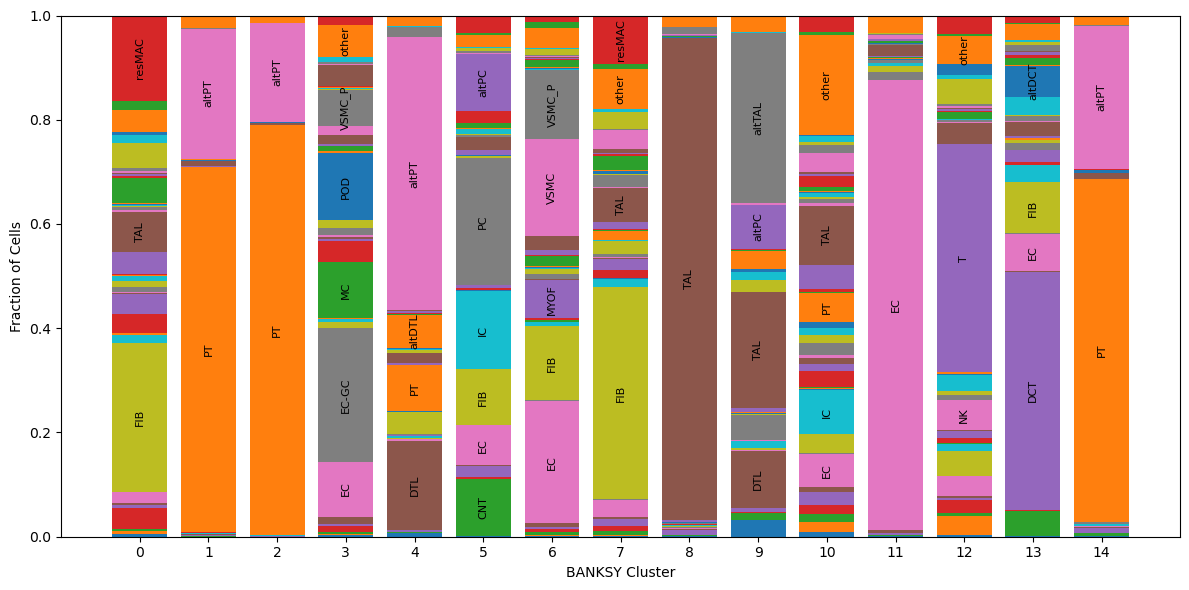

In [59]:
fig, ax = plt.subplots(figsize=(12,6))
bottom = [0] * proportions.shape[0]

for col in proportions.columns:
    values = proportions[col].values
    bars = ax.bar(proportions.index, values, bottom=bottom, label=col)

    for i, (val, b) in enumerate(zip(values, bottom)):
        if val > 0.05:
            ax.text(i, b + val / 2, col, ha='center', va='center', fontsize = 8, rotation = 90)

    bottom = [b+v for b, v in zip(bottom, values)]

ax.set_ylabel("Fraction of Cells")
ax.set_xlabel("BANKSY Cluster")
ax.set_xticks(range(len(proportions.index)))
ax.set_xticklabels(proportions.index, rotation=0)
plt.tight_layout()
plt.show()

In [60]:
adata.obs['sample'].unique()

array(['3729_Xen21', '3809_Xen22A', '3809_Xen22B', '3811_Xen21'],
      dtype=object)

In [4]:
sample_name = "3811_Xen21"

# create a mask on adata.obs
mask = adata.obs['sample'] == sample_name

# subset and .copy() to get an independent AnnData
adata_sub = adata[mask, :].copy()

# quick check
adata_sub

AnnData object with n_obs × n_vars = 26489 × 300
    obs: 'x_centroid', 'y_centroid', 'cell_label', 'manual_annotations', 'sample', 'banksy_clusters'
    obsm: 'coord_xy'

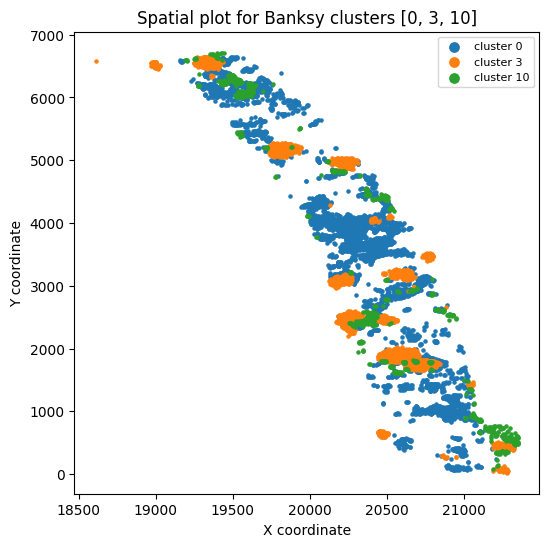

In [6]:
import matplotlib.pyplot as plt

clusters_of_interest = [0, 3, 10]
coords_all = adata_sub.obsm['coord_xy']
cluster_ids = adata_sub.obs['banksy_clusters']

# choose a discrete colormap
cmap = plt.get_cmap('tab10')

plt.figure(figsize=(6,6))
for i, cl in enumerate(clusters_of_interest):
    mask = (cluster_ids == cl)
    coords = coords_all[mask]
    plt.scatter(
        coords[:, 0],
        coords[:, 1],
        s=5,
        color=cmap(i),          # pick the i-th color
        label=f'cluster {cl}'
    )

plt.legend(markerscale=3, fontsize=8)
plt.xlabel('X coordinate')
plt.ylabel('Y coordinate')
plt.title(f"Spatial plot for Banksy clusters {clusters_of_interest}")
plt.show()


In [64]:
adata

AnnData object with n_obs × n_vars = 71456 × 300
    obs: 'x_centroid', 'y_centroid', 'cell_label', 'manual_annotations', 'sample', 'banksy_clusters'
    obsm: 'coord_xy'

In [13]:
banksy_clusters_df = adata.obs[['cell_label', 'banksy_clusters']].copy()
banksy_clusters_df.index.name = 'cell.id' 
#clusters_of_interest = [0, 3, 10] 
#banksy_clusters_df = banksy_clusters_df[banksy_clusters_df['banksy_clusters'].isin(clusters_of_interest)]
banksy_clusters_df.to_csv("/storage2/fs1/sanjayjain/Active/Asmita/3811_banksycelltypes_allniches.csv")

In [12]:
banksy_clusters_df['banksy_clusters'].unique()

array([ 0, 10,  3], dtype=int32)

In [3]:
adata= sc.read_h5ad("/storage2/fs1/sanjayjain/Active/Xenium/Banksy_Atlas/Banksy_4_Biopsies.h5ad")